<a href="https://colab.research.google.com/github/samuelhurni/ML-Cellsegmentation-HSLU-FS24/blob/feature_Sam/Sartorius_segmentation_kaggle_Sam_v012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Sartorius - Cell Instance Segmentation
##Detect single neuronal cells in microscopy images

Project HSLU Master IT Digitalization & Sustainability
Module: Machine Learning and Data Science
* Samuel Hurni
* Pradanendr Sudev  
* Chakravarti Devanandini




### 0.1 General information and references

Used Third party Libraries:
* Pytorch
* TQDM
* Pandas
* Numpy
* gdown
* Matplotlib

Used Thid party Imports:
* Auxiliary functions metric: "https://www.kaggle.com/code/theoviel/competition-metric-map-iou
* Auxiliary functions for encoding and decoding the mask: "https://www.kaggle.com/code/enzou3/sartorius-mask-r-cnn"



References to Turtorials / Code documantation:
* Pytorch documentation: https://pytorch.org/docs/stable/index.html
* Pytorch Turtorial: https://www.learnpytorch.io/00_pytorch_fundamentals/
* Kaggel dataset for ideas: https://www.kaggle.com/code/enzou3/sartorius-mask-r-cnn
  * build own method based on `find_best_thresholds()`



  **Important:**
  **Please check the Hyperparameters for this File because this allows you for example to run the project with limited images or load pretrained models**

### 0.2 About the project

Link to the project as follow: https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation




Main objectives:

This Kaggle competition is about creating a computer program to identify and outline individual nerve cells in microscope images. These nerve cells are important for studying brain diseases like Alzheimer's and brain tumors, which are major health problems worldwide. Typically, scientists look at these cells using a microscope, but finding each cell in the images can be tough and takes a lot of time. Doing this accurately could help find new treatments for these diseases.

The challenge is that current methods aren't very good at recognizing these nerve cells, especially a kind called neuroblastoma cells, which look very different from other cells and are hard to identify with existing tools.

Sartorius, a company that supports science and medicine research, is sponsoring this competition. They want participants to develop a method that can automatically and precisely identify different types of nerve cells in images. This would be a big step forward in neurological research, making it easier for scientists to understand how diseases affect nerve cells and possibly leading to the discovery of new medications.



Dataset:

The Dataset containa at arround xx images for training and xx images for testing. the goal would be to train a model whoch is able to segment neuronal cells.


The ground truth data to the images for training consist several meta data which includes also the masks for training the segmentation problem. These are specified field of ecah datapoint:


* _id - unique identifier for object_

* _annotation - run length encoded pixels for the identified neuronal cell_

* _width - source image width_

* _height - source image height_

* _cell_type - the cell line_

* _plate_time - time plate was created_

* _sample_date - date sample was created_

* _sample_id - sample identifier_

* _elapsed_timedelta - time since first image taken of sample_



## 1.Preparations: Loading Dataset and install or import Packages

### 1.1 Install adn import third party packages / functions

In this chapter we install the third party packages which maybe are not installed in the prebuild google collab or on your local system

* Tqdm --> progress bar
* gdown --> Import google drive package


In [ ]:
# Install gdown:
try:
    import gdown
except ImportError:
    !pip install gdown

# Install tqdm:
try:
    import tqdm
except ImportError:
    !pip install tqdm

In [ ]:
# General Import which are used in this file
import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import requests
import zipfile
from pathlib import Path
import gdown
from sklearn.metrics import fbeta_score

###1.2 Hyperparameters

In [ ]:
BASE_PATH = "dataset/sartorius-cell-instance-segmentation"
TRAIN_PATH = BASE_PATH + "/train"
TEST_PATH = BASE_PATH + "/test"
TRAIN_CSV = BASE_PATH + "/train.csv"

IMG_WIDTH = 704
IMG_HEIGHT = 520

TEST = False

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# # Will be used to normalize pictures
# RESNET_MEAN = (0.485, 0.456, 0.406)
# RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 1

MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# Confidence required for a pixel to be kept for a mask
MASK_THRESHOLD = 0.5

# Dictionaries to classify each type of cell
CELL_TYPE_DICT = {"astro": 0, "cort": 1, "shsy5y": 2}
DICT_TO_CELL = {0: "astro", 1: "cort", 2: "shsy5y"}
MASK_THRESHOLD_DICT = {1: 0.55, 2: 0.75, 3:  0.6}
MIN_SCORE_DICT = {1: 0.55, 2: 0.75, 3: 0.5}

# Normalize to resnet mean and std if True.
NORMALIZE = False


# Using a learning rate scheduler
USE_SCHEDULER = True

# Number of epochs in training
NUM_EPOCHS = 8

BOX_DETECTIONS_PER_IMG = 539

### 1.2 Define custom functions for this Project:

In this chapter we are defining custom functions which we are using throughout this project:

* `show_train_time` function to show the time how long the coputation of the model takes
* `folder_content` function to display what is inside a folder
* `check_drop_image_existence` function to drop from the label dataset images which are not in the file system
* `accuracy_fn` function for multi-label calssification problems
* `plot_loss_values` for plotting the loss and accuracy to detect under or overfitting
* `model_rating` gives back the rating of the model with accuracy and score for a given dataloader dataset
* `make_pred` make predictions with a model based on test data
* `combine_models_predictions_2` combines the results of two models with the size of 4 and 13 labels to a result of 17 labels
* `make_pred_combined` make predctions for the combined approach  with two models, one for the weather labels and another for the other labelsm



In [ ]:
# Define the timing function:
from timeit import default_timer as timer
def show_train_time(start:float,
                     end:float,
                     device: torch.device = None):
  """Show differnences between start and end time for calculation the performance of a pytorch model"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
def folder_content(directory_path):
  """
  Iterating thorugh all folders in the path and display the content.
  Args:
    directory_path --> Path to start iteration

  Returns:
    Show information about:
      subdiretories in dir_path
      number of files in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(directory_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
def check_drop_image_existence(label_data: pd.DataFrame, images_dir : string):
  """
  Method which cleans the label dataframe by checking the existence of images
  """
  data_frame = label_data
  index_drop = []
  #print(f"Check Images in Folder {images_dir}")
  for index, row in tqdm(data_frame.iterrows(), desc="Checking if File Exists....."):
    path_to_check = os.path.join(images_dir, row['image_name'])
    file_exists = os.path.isfile(path_to_check)
    if file_exists == False:
      # File does not exist, drop row from dataset
      #print(f"File: {row['image_name']} in Label file does not exist as image and will be deleted from the label file")
      index_drop.append(index)

  #Drop all rows in index_drop
  for index in tqdm(index_drop, desc="Deleting rows in label dataset....."):
    data_frame.drop(index, inplace=True)
  return data_frame

In [ ]:
# transformation functions

# Adjustments to PyTorch transformation classes to accommodate masks and targets
# Inspired by Abishek and DATAISTA0's approach

import torch
import random
from torchvision.transforms import functional as TF

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

class FlipVertically:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-2)
            box = label["boxes"]
            box[:, [1, 3]] = pic_height - box[:, [3, 1]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-2)
        return pic, label

class FlipHorizontally:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-1)
            box = label["boxes"]
            box[:, [0, 2]] = pic_width - box[:, [2, 0]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-1)
        return pic, label





class Normalize:
    """Normalize tensor image with mean and standard deviation."""
    def __call__(self, pic, label):
        pic = TF.normalize(pic, mean=RESNET_MEAN, std=RESNET_STD)
        return pic, label

class ConvertToTensor:
    """Convert PIL Image or numpy.ndarray to Tensor."""
    def __call__(self, pic, label):
        # Ensure pic is converted to a tensor using torchvision's functional API
        pic = TF.to_tensor(pic)
        return pic, label




def get_transforms(training):
    base_transforms = [ConvertToTensor()]
    if training:
        # Augmentations for the training dataset
        augmentations = [
            FlipHorizontally(likelihood=0.5),  # Assuming a 50% chance to apply
            FlipVertically(likelihood=0.5),  # Assuming a 50% chance to apply
        ]
        base_transforms.extend(augmentations)

    # Always apply normalization last
    base_transforms.append(Normalize())

    return Compose(base_transforms)


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, label):
        for t in self.transforms:
            image, label = t(image, label)
        return image, label



# def transforms(training):
#     base_transforms = [ConvertToTensor()]
#     if NORMALIZE:
#         base_transforms.append(Standardize())

#     # Augmentations only for the training set
#     if training:
#         augmentations = [
#             FlipHorizontally(0.5),
#             FlipVertically(0.5),
#         ]
#         if NORMALIZE:  # Avoid appending Standardize twice if already added
#             base_transforms.extend(augmentations)
#         else:
#             base_transforms += [Standardize()] + augmentations

#     return ChainTransforms(base_transforms)


In [ ]:
import torch
from torchvision.transforms import functional as F

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

# class ConvertToTensor:
#     """Convert PIL Image to Tensor."""
#     def __call__(self, pic, label):
#         pic = F.to_tensor(pic)
#         return pic, label

# class Normalize:
#     """Normalize Tensor image with mean and standard deviation."""
#     def __call__(self, pic, label):
#         pic = F.normalize(pic, mean=RESNET_MEAN, std=RESNET_STD)
#         return pic, label

# def get_transforms(training):
#     transforms = [ConvertToTensor()]
#     if training:
#         # Add any data augmentation transforms here for training
#         pass
#     transforms.append(Normalize())  # Normalize last to maintain [0,1] range for augmentations
#     return Compose(transforms)


In [ ]:

def decode_rle(rle_string, dimensions, fill_value=1):
    """
    Decodes a run-length encoded string into a binary mask.

    Parameters:
    - rle_string: The run-length encoded string (e.g., "2 3 5 2" means start at 2, length 3, start at 5, length 2)
    - dimensions: Tuple indicating the shape of the output mask (height, width)
    - fill_value: The value to fill the mask with where the RLE indicates; default is 1

    Returns:
    - A 2D numpy array representing the mask, where filled areas are marked with `fill_value` and the rest are 0.
    """

    # Split the RLE string into a list of strings, then convert every string into an integer
    numbers = [int(num) for num in rle_string.split()]

    # Extract start positions and lengths from the list of numbers
    start_positions = numbers[::2]
    lengths = numbers[1::2]

    # Calculate end positions for each run
    end_positions = [start + length for start, length in zip(start_positions, lengths)]

    # Initialize a flat image array with zeros
    flat_image = np.zeros(dimensions[0] * dimensions[1], dtype=np.float32)

    # Fill the specified positions in the flat image array
    for start, end in zip(start_positions, end_positions):
        flat_image[start:end] = fill_value

    # Reshape the flat image array back into the specified dimensions
    return flat_image.reshape(dimensions)



In [ ]:
import numpy as np

def encode_rle(image_matrix):
    """
    Encodes a binary image matrix into a run-length encoding string.

    Parameters:
    - image_matrix: A 2D numpy array representing the image to be encoded. Expected to contain binary values (0s and 1s).

    Returns:
    - A string representing the run-length encoded image, where each pair of numbers represents a start position and the length of consecutive 1s.
    """

    # Find indices of all 1s in the flattened image array
    one_positions = np.where(image_matrix.flatten() == 1)[0]

    # Initialize the list to hold the encoding
    encoding = []

    # Track the previous position to determine the start of a new run
    previous_position = -2

    # Iterate through all positions of 1s
    for position in one_positions:
        # If current position is not consecutive, start a new run
        if position > previous_position + 1:
            encoding.extend((position + 1, 0))  # +1 for 1-based indexing
        encoding[-1] += 1  # Increment the length of the current run
        previous_position = position

    # Join all elements in the list as a string separated by spaces
    return ' '.join(map(str, encoding))


In [ ]:
import numpy as np

def eliminate_overlaps(primary_mask, additional_masks):
    """
    Removes pixels from the primary mask where it overlaps with any of the additional masks.

    Parameters:
    - primary_mask: A 2D numpy array representing the primary mask to be modified.
    - additional_masks: A list of 2D numpy arrays, each representing a mask to check for overlaps with the primary mask.

    Returns:
    - The modified primary mask with overlapping pixels set to 0.
    """

    # Iterate through each of the additional masks
    for mask in additional_masks:
        # Find overlapping pixels between the primary mask and the current additional mask
        overlap = np.logical_and(primary_mask, mask)

        # Check if there is any overlap
        if np.sum(overlap) > 0:
            # Set overlapping pixels in the primary mask to 0
            primary_mask[overlap] = 0

    # Return the modified primary mask
    return primary_mask


In [ ]:
import numpy as np

def create_boxed_image(coordinates):
    """
    Draws a rectangular box on an image represented by a numpy array, based on given coordinates.

    Parameters:
    - coordinates: A list of four elements representing the box's corners [xmin, ymin, xmax, ymax].

    Returns:
    - A 2D numpy array (image) with dimensions IMG_HEIGHT x IMG_WIDTH,
      where pixels inside the box are set to 1, and the rest are 0.
    """

    # Initialize a blank image with zeros
    image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Extract and convert the box coordinates to integers
    xmin, ymin, xmax, ymax = map(int, coordinates)

    # Draw top and bottom lines of the box
    for x in range(xmin, xmax):
        if xmin != 0 and xmax != IMG_WIDTH:  # Check to prevent drawing outside the image
            image[ymin-1][x] = 1  # Draw top line
            image[ymax-1][x] = 1  # Draw bottom line

    # Draw left and right lines of the box
    for y in range(ymin, ymax):
        if ymin != 0 and ymax != IMG_HEIGHT:  # Check to prevent drawing outside the image
            image[y][xmax-1] = 1  # Draw right line
            image[y][xmin-1] = 1  # Draw left line

    # Return the image with the drawn box
    return image


In [ ]:
import numpy as np

def find_bounding_box(mask):
    """
    Calculates the bounding box of a non-zero area in a mask.

    Parameters:
    - mask: A 2D numpy array representing the mask from which to calculate the bounding box.

    Returns:
    - A list containing the coordinates of the bounding box: [xmin, ymin, xmax, ymax].
    """

    # Find the indices of non-zero elements in the mask
    nonzero_indices = np.where(mask)

    # Calculate the minimum and maximum x (column) indices
    left_bound = np.min(nonzero_indices[1])
    right_bound = np.max(nonzero_indices[1])

    # Calculate the minimum and maximum y (row) indices
    top_bound = np.min(nonzero_indices[0])
    bottom_bound = np.max(nonzero_indices[0])

    # Return the bounding box coordinates
    return [left_bound, top_bound, right_bound, bottom_bound]


In [ ]:
import numpy as np

def merge_masks(mask_list, threshold):
    """
    Merges multiple masks into a single image, assigning a unique integer to each mask's area based on its order in the list,
    but only for mask values above a specified threshold.

    Parameters:
    - mask_list: A list of 2D numpy arrays (masks) to be merged. Each mask should have the same dimensions.
    - threshold: A value that defines the minimum intensity for pixels to be considered part of a mask.

    Returns:
    - A 2D numpy array where each pixel's value corresponds to the order of the mask it belongs to,
      or 0 if it does not belong to any mask or does not meet the threshold.
    """

    # Initialize an empty image with the same dimensions as the masks
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Iterate through each mask with its order starting from 1
    for order, mask in enumerate(mask_list, 1):
        # Update the combined image with the order number where the mask exceeds the threshold
        #print(order)
        #print(mask.shape)
        combined_image[mask > threshold] = order

    return combined_image


In [ ]:
import numpy as np

def merge_masks_and_boxes(mask_image, box_image):
    """
    Combines mask and box images into one, ensuring that the boxes overlay the masks and
    have the highest value present in the mask image.

    Parameters:
    - mask_image: A 2D numpy array representing multiple masks, where non-zero values indicate mask presence.
    - box_image: A 2D numpy array representing multiple boxes, marked as 1's for box edges and 0's for the background.

    Returns:
    - A 2D numpy array where both boxes and masks are combined. Boxes will overlay masks with the highest mask value found.
    """

    # Initialize a result image with zeros
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Find the highest value in the mask_image
    max_mask_value = np.max(mask_image)

    # First pass: Copy mask values to the combined image
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            combined_image[y, x] = mask_image[y, x]

    # Second pass: Overlay boxes on the combined image, setting them to the highest mask value
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            if box_image[y, x] != 0:  # If there's a box pixel, overlay it with the max mask value
                combined_image[y, x] = max_mask_value

    return combined_image


In [ ]:
def filter_masks(predictions):
    """
    Filters predicted masks based on a minimum score threshold for each mask and
    a maximum threshold for pixel values, specific to each label.

    Parameters:
    - predictions: A dictionary containing 'masks', 'scores', and 'labels' from a prediction model.

    Returns:
    - A list of binary mask arrays that have passed the score and pixel value thresholds and have been filtered for overlaps.
    """

    filtered_masks = []  # Initialize the list to store filtered masks

    # Iterate through each mask and its associated score and label
    for index, mask in enumerate(predictions["pred_masks"]):

        #print(index)
        prob = predictions['pred_logits'].softmax(-1)[:, :] #was before -1 at the last dimension to remove the 4th probability (noelement)
        #print(f"prob shape {prob.shape}")
        #print(f"prob values {prob}")
        # keep = prob.max(-1).values > 0.7
        # prob[keep] of shape [num objects] --> inside is object label (0,1,2,3,4)
        max_values, max_indices = torch.max(prob, dim=1)
        score = max_values[index].cpu().item()  # Convert score tensor to a Python float
        #print(f"len of max_indices shape {max_indices.shape}")
        #print(f"len of max_indices resutl {max_indices}")
        labels = pd.Series(max_indices.cpu().numpy()).value_counts()
        #print(labels)
        #print(index)
        label = max_indices[index].cpu().numpy().item() # Convert label tensor to a Python int
        #print(score)
        #print(label)
        #print(MIN_SCORE_DICT[label])
        # Check if the score exceeds the minimum score for the given label
        if score > MIN_SCORE_DICT[label]:
            mask_array = mask.cpu().numpy().squeeze()  # Convert the mask to a numpy array and remove any extra dimensions
            #print(f"mask array {mask_array.shape}")
            # Apply a threshold to create a binary mask where pixel values indicate high likelihood
            high_confidence_mask = mask_array > MASK_THRESHOLD_DICT[label]
            # Remove pixels in the current mask that overlap with any of the previously added masks
            high_confidence_mask = eliminate_overlaps(high_confidence_mask, filtered_masks)
            # Add the processed mask to the list of filtered masks
            filtered_masks.append(high_confidence_mask)
    #print(len(filtered_masks))
    return filtered_masks

#### 1.2.2 Metrics

The **Intersection over Union (IoU)** score, also known as the **Jaccard Index**, is a metric used in image segmentation to evaluate the accuracy of an object detector. It quantifies the precision of segmentation by measuring the overlap between the predicted segmentation area and the ground truth area.

The IoU score is calculated as follows:

$$ \text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}} $$

- **Area of Overlap**: The intersection area where both the predicted segmentation and the ground truth agree on the presence of an object.
- **Area of Union**: The combined area of the predicted segmentation and the ground truth, encompassing any part of the object present in either.

IoU scores range from **0** to **1**, where a score of **1** indicates perfect agreement between the predicted segmentation and the ground truth, and a score of **0** indicates no overlap.

This metric is pivotal for:
- Evaluating the precision of object detections within an image.
- Averaging performance across a dataset to gauge the general efficacy of a segmentation model.
- Calculating critical detection task metrics like true positives, false positives, and false negatives.



In [ ]:
def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union

    return iou

In [ ]:
import numpy as np

def calculate_precision(threshold, iou_matrix):
    """
    Calculates precision metrics at a specified IoU threshold.

    Parameters:
    - threshold (float): The IoU threshold for determining if a detection is a true positive.
    - iou_matrix (np.array): The IoU score matrix between ground truth and predicted objects.

    Returns:
    - int: The number of true positives (TP) at the given threshold.
    - int: The number of false positives (FP) at the given threshold.
    - int: The number of false negatives (FN) at the given threshold.
    """

    # Determine matches based on the IoU threshold
    is_match = iou_matrix > threshold

    # True positives: Predictions that match a ground truth object exactly once
    true_positives_count = np.sum(is_match, axis=1) == 1

    # False positives: Predictions that do not match any ground truth object
    false_positives_count = np.sum(is_match, axis=0) == 0

    # False negatives: Ground truth objects not matched by any prediction
    false_negatives_count = np.sum(is_match, axis=1) == 0

    # Sum up the counts for TP, FP, FN
    tp = np.sum(true_positives_count)
    fp = np.sum(false_positives_count)
    fn = np.sum(false_negatives_count)

    return tp, fp, fn


In [ ]:
import numpy as np

def calculate_mean_average_precision(ground_truth_masks, predicted_masks, verbose=0):
    """
    Calculates the mean Average Precision (mAP) for a set of ground truth and predicted masks,
    where each mask represents segmented objects with unique values and the background is 0.

    Parameters:
    - ground_truth_masks (list of np.array): List of 2D numpy arrays representing ground truth masks.
    - predicted_masks (list of np.array): List of 2D numpy arrays representing predicted masks.
    - verbose (int, optional): Level of verbosity for printing detailed info. Defaults to 0.

    Returns:
    - float: The mean Average Precision (mAP) score.
    """
    # Compute IoU for each pair of ground truth and predicted masks
    iou_scores = [compute_iou(truth, pred, verbose) for truth, pred in zip(ground_truth_masks, predicted_masks)]

    # Initialize list to hold precision scores for different thresholds
    precision_scores = []

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    # Evaluate precision at different IoU thresholds from 0.5 to 0.95 with step of 0.05
    for threshold in np.arange(0.5, 1.0, 0.05):
        total_tp, total_fp, total_fn = 0, 0, 0  # Initialize counters for true positives, false positives, false negatives

        # Calculate precision metrics for each IoU matrix
        for iou_matrix in iou_scores:
            tp, fp, fn = calculate_precision(threshold, iou_matrix)
            total_tp += tp
            total_fp += fp
            total_fn += fn

        # Compute precision for the current threshold
        precision = total_tp / (total_tp + total_fp + total_fn)
        precision_scores.append(precision)

        if verbose:
            # Print detailed precision info at the current threshold
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(threshold, total_tp, total_fp, total_fn, precision))

    # Calculate the mean of the collected precision scores
    mean_ap = np.mean(precision_scores)

    if verbose:
        # Print the overall mean Average Precision
        print("AP\t-\t-\t-\t{:1.3f}".format(mean_ap))

    return mean_ap


In [ ]:
# from tqdm import tqdm
# import pandas as pd
# import torch

# def calculate_average_iou_score(dataset, model):
#     """
#     Calculates the average Intersection over Union (IoU) mean Average Precision (mAP) score across a dataset.

#     Parameters:
#     - dataset: The dataset to evaluate, where each item is a tuple of an image and its associated targets.
#     - model: The prediction model to use for generating mask predictions.

#     Returns:
#     - float: The average IoU mAP score for the dataset.
#     """
#     model.eval()  # Set the model to evaluation mode
#     total_iou_score = 0  # Initialize total IoU score

#     # Iterate over all items in the dataset
#     for img, targets in tqdm(dataset, desc="Evaluating dataset"):
#         with torch.no_grad():  # Disable gradient calculation for inference
#             predictions = model([img.to(DEVICE)])[0]  # Perform prediction

#         # Combine ground truth masks using a fixed threshold
#         ground_truth_masks = merge_masks(targets['masks'], 0.5)

#         # Determine the most frequent predicted label
#         label_counts = pd.Series(predictions['labels'].cpu().numpy()).value_counts()
#         most_frequent_label = label_counts.sort_values().index[-1]

#         # Get the mask threshold for the most frequent label
#         mask_threshold = MASK_THRESHOLD_DICT[most_frequent_label]

#         # Combine predicted masks using the determined threshold
#         predicted_masks = merge_masks(filter_masks(predictions), mask_threshold)

#         # Compute IoU mAP score for the current image and update the total score
#         total_iou_score += calculate_mean_average_precision([ground_truth_masks], [predicted_masks])

#     # Calculate the average IoU mAP score across the dataset
#     average_iou_score = total_iou_score / len(dataset)

#     return average_iou_score


### 1.3 Checking for GPU and device agnostic code (Cuda(Nvidia / Apple Silicon)

In this chapter we are checking if Hardware from Nvidia (Cuda framework) pr Apple Silicon (M1-M3) is available and switching the device

In [ ]:
#Setup device agnostic code
import torch
device="cpu"
if torch.backends.mps.is_available():
  print("Metal available with Apple Silicon GPU")
  device = "mps"
elif torch.cuda.is_available():
  device = "cuda"
  print("Cuda available with Nvidia GPU")

Cuda available with Nvidia GPU


### 1.4 Define Hyperparameter for Project:
Her we have the hyperparameters for all three models:




### 1.5 Downloading the dataset to Google Colab

In this chapter we are downloading the dataset from a public Google Drive link to this colab instance. This is necessary to decrease the request time per image to the dataset:

In [ ]:
from pathlib import Path
import zipfile
import gdown

# Setup paths and folders names and urls
data_path = Path("dataset")
download_path = Path("kaggledownload")

#dataset_url = 'https://drive.google.com/uc?id=1syZoLGGeFiFErCFL_iI1VO_4k2jLEaPv&confirm=t'
dataset_url = 'https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t'


# If the image folder doesn't exist, download it
if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"Did not find {data_path} directory, creating one...")
    data_path.mkdir(parents=True, exist_ok=True)
    download_path.mkdir(parents=True, exist_ok=True)

print("Downloading dataset...")
gdown.download(dataset_url, str(download_path / "sartorius-cell-instance-segmentation_2.zip"), quiet=False)




Did not find dataset directory, creating one...


Downloading...
From: https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t
To: /content/kaggledownload/sartorius-cell-instance-segmentation_2.zip
100%|██████████| 2.48G/2.48G [00:55<00:00, 44.3MB/s]


'kaggledownload/sartorius-cell-instance-segmentation_2.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
x = torch.randn(1, 512, 374)
print(x.shape)


x = torch.permute(x, (0, 2, 1))
print(x.shape)

torch.Size([1, 512, 374])
torch.Size([1, 374, 512])


In [ ]:
%ls

dataset/  drive/  kaggledownload/  sample_data/


In [ ]:
%cd "drive/"

/content/drive


In [ ]:
%cd "My Drive/"

/content/drive/My Drive


In [ ]:
%cd "ai_data/"

/content/drive/My Drive/ai_data


In [ ]:
%cd "ML_FS24"


/content/drive/My Drive/ai_data/ML_FS24


In [ ]:
%cd "FinalProject/"

/content/drive/My Drive/ai_data/ML_FS24/FinalProject


In [ ]:
%cd /content


/content


In [ ]:
!cp "/content/drive/My Drive/ai_data/ML_FS24/FinalProject/Dataset/sartorius-cell-instance-segmentation.zip" "./kaggledownload/"


In [ ]:

# Unzip data
with zipfile.ZipFile(str(download_path / "sartorius-cell-instance-segmentation.zip"), "r") as zip_ref:
    print("Unzipping train dataset data...")
    zip_ref.extractall(data_path)

Unzipping train dataset data...


## 2.Dataset preparation

In this chapter we are preparing our dataset, that we are able to load it later on into a Pytorch Dataloader:

* Load dataset from path


In [ ]:

def normalize_bbox(bboxes, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        normalized_bbox = (x_min / cols, y_min / rows, x_max / cols, y_max / rows)
        # Check if any of the normalized values are greater than 1
        if any(coord > 1 for coord in normalized_bbox):
            print(f"Normalized values greater than 1 detected: {normalized_bbox}")

        normalized_bboxes.append(normalized_bbox)
    return normalized_bboxes


def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return denormalized_bboxes

In [ ]:
import collections
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.ops import box_convert, generalized_box_iou

class ImageCellDataset(Dataset):
    def __init__(self, directory_path, data_frame, transformation_steps=None):
        self.transformation_steps = transformation_steps
        self.directory_path = directory_path
        self.data_frame = data_frame
        self.img_height = IMG_HEIGHT
        self.img_width = IMG_WIDTH
        self.cells_data = collections.defaultdict(dict)

        grouped_df = self.data_frame.groupby(['id', 'cell_type'])['annotation'].apply(list).reset_index()

        for idx, record in grouped_df.iterrows():
            self.cells_data[idx] = {
                'cell_id': record['id'],
                'file_path': os.path.join(self.directory_path, record['id'] + '.png'),
                'cell_annotations': record["annotation"],
                'type': CELL_TYPE_DICT[record["cell_type"]]
            }


    # get the item and load annotations (mask) accordingly
    def __getitem__(self, index):
        cell_data = self.cells_data[index]
        image_file = cell_data["file_path"]
        image = Image.open(image_file).convert("RGB")
        num_objects = len(cell_data['cell_annotations'])
        masks = np.zeros((num_objects, self.img_height, self.img_width), dtype=np.uint8)
        bounding_boxes = []

        for i, annotation in enumerate(cell_data['cell_annotations']):
            decoded_mask = decode_rle(annotation, (self.img_height, self.img_width))
            decoded_mask = Image.fromarray(decoded_mask)
            decoded_mask = np.array(decoded_mask) > 0
            masks[i, :, :] = decoded_mask
            box = find_bounding_box(decoded_mask)

            bounding_boxes.append(box)


        # Prepare labels based on cell type
        labels = [cell_data["type"] for _ in range(num_objects)]

        # Convert bounding_boxes from Corner Points Format to CXCW format
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)  # Ensure bounding_boxes is a torch tensor




        # print(f"Bounding box initial: {bounding_boxes[0]}")

        # print(f"Bounding box after convertion: {bounding_boxes[0]}")
        #bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        cell_id_tensor = torch.tensor([index])
        areas = (bounding_boxes[:, 3] - bounding_boxes[:, 1]) * (bounding_boxes[:, 2] - bounding_boxes[:, 0])
        not_crowded = torch.zeros((num_objects,), dtype=torch.int64)

        target_dict = {
            'boxes': bounding_boxes,
            'labels': labels,
            'masks': masks,
            'image_id': cell_id_tensor,
            'area': areas,
            'iscrowd': not_crowded
        }


        if self.transformation_steps:
            image, target_dict = self.transformation_steps(image, target_dict)

        # do normalization and conversation here
        boxes = target_dict['boxes']
        converted_boxes = torch.zeros_like(boxes)

        for i, box in enumerate(boxes):
            converted_boxes[i] = box_convert(box, in_fmt='xyxy', out_fmt='cxcywh')
            #print(converted_boxes[i])
        bounding_boxes = converted_boxes
        bounding_boxes = normalize_bbox(bounding_boxes,rows=520,cols=704)
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)  # Ensure bounding_boxes is a torch tensor


        target_dict['boxes'] = bounding_boxes
        return image, target_dict

    def __len__(self):
        return len(self.cells_data)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate

def custom_collate_fn(batch):
    images, targets = zip(*batch)  # Unpack the batch of images and targets
    images = torch.stack(images, dim=0)  # Stack images as they should be of the same size

    # Handle variable-sized targets manually
    # Assuming targets is a dictionary with keys like 'boxes', 'labels', etc.
    # We'll collect these into lists or whatever format your model expects
    collated_targets = {}
    for key in targets[0].keys():
        if isinstance(targets[0][key], torch.Tensor):
            # For tensor-type data that's variable-sized, use a list to avoid size mismatch issues
            collated_targets[key] = [target[key] for target in targets]
        else:
            # Use default_collate for data that can be directly collated
            collated_targets[key] = default_collate([target[key] for target in targets])

    return images, collated_targets



# df_train = pd.read_csv(TRAIN_CSV, nrows=5000 if TEST else None)

# dataset_train = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=True))
# # dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)



In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
def custom_collate_fn(batch):
    images, targets = zip(*batch)  # Unpack the batch of images and targets
    images = torch.stack(images, dim=0)  # Stack images as they should be of the same size

    # Handle variable-sized targets manually
    # Assuming targets is a dictionary with keys like 'boxes', 'labels', etc.
    # We'll collect these into lists or whatever format your model expects
    collated_targets = {}
    for key in targets[0].keys():
        if isinstance(targets[0][key], torch.Tensor):
            # For tensor-type data that's variable-sized, use a list to avoid size mismatch issues
            collated_targets[key] = [target[key] for target in targets]
        else:
            # Use default_collate for data that can be directly collated
            collated_targets[key] = default_collate([target[key] for target in targets])

    return images, collated_targets


# Load your dataset DataFrame
df_train = pd.read_csv(TRAIN_CSV, nrows=5000 if TEST else None)

# Initialize your full dataset with transformations
full_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=True))


dl_train_test = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)



# Generate indices and split them
indices = list(range(len(full_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.01, random_state=42)

# Create Subset objects for train and validation sets
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)

# Initialize DataLoaders for the train and validation subsets
dl_train = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
dl_val = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)


In [ ]:
print("Val Image len:", len(dl_train))
first_batch = next(iter(dl_train))
images, targets = first_batch
print("Batch images type:", type(images))
print("Batch images shape:", images.shape if isinstance(images, torch.Tensor) else "N/A")
print("Batch targets type:", type(targets))
print("Batch targets type:", type(targets['masks'][0]))
print("Lenth targets list:", len(targets['masks']))
#print("mask targets type elemt 2:", targets['masks'][1].shape)

Val Image len: 484


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch images type: <class 'torch.Tensor'>
Batch images shape: torch.Size([1, 3, 520, 704])
Batch targets type: <class 'dict'>
Batch targets type: <class 'torch.Tensor'>
Lenth targets list: 1


In [ ]:
print("Val Image len:", len(dl_val))
first_batch = next(iter(dl_val))
images, targets = first_batch
print("Batch images type:", type(images))
print("Batch images shape:", images.shape if isinstance(images, torch.Tensor) else "N/A")
print("Batch targets type:", type(targets))
print("Batch targets type:", type(targets['masks'][0]))
print("Lenth targets list:", len(targets['masks']))
#print("mask targets type elemt 2:", targets['masks'][1].shape)

Val Image len: 122
Batch images type: <class 'torch.Tensor'>
Batch images shape: torch.Size([1, 3, 520, 704])
Batch targets type: <class 'dict'>
Batch targets type: <class 'torch.Tensor'>
Lenth targets list: 1


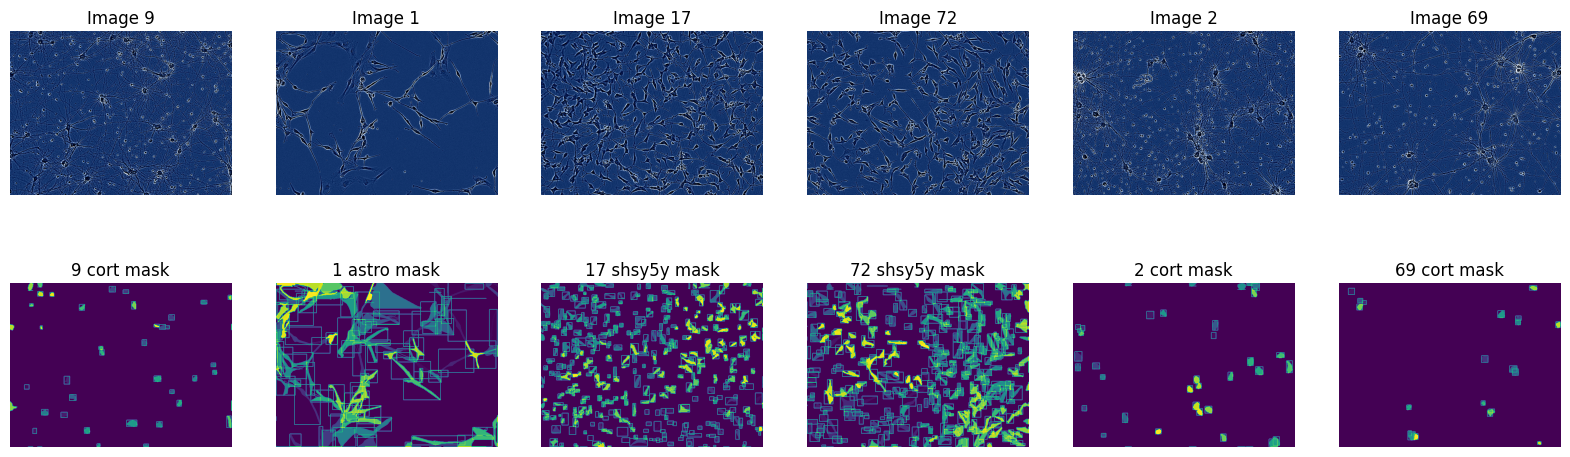

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def display_sampled_images(columns_count):
    '''
    columns_count : number of images to display
    This function displays a 2-row plot with 'columns_count' images on each row from the training dataset.
    The first row shows the images, and the second row shows the corresponding masks and boxes.
    '''
    sample_indexes = random.sample(range(100), columns_count)
    figure, axis = plt.subplots(2, columns_count, figsize=(20, 6))

    for column in range(columns_count):
        image, annotations = full_dataset[sample_indexes[column]]
        all_masks = np.zeros((IMG_HEIGHT, IMG_WIDTH))
        all_boxes = np.zeros((IMG_HEIGHT, IMG_WIDTH))
        axis[0][column].set_title(f"Image {sample_indexes[column]}")
        axis[0][column].imshow(image.numpy().transpose((1, 2, 0)))
        axis[0][column].axis("off")

        for mask in annotations['masks']:
            bounding_box = find_bounding_box(mask)
            all_boxes = np.logical_or(all_boxes, create_boxed_image(bounding_box))

        all_masks = merge_masks(annotations['masks'], 0.5)

        axis[1][column].set_title(f"{sample_indexes[column]} {DICT_TO_CELL[annotations['labels'][0].item()]} mask")
        combined_detections = merge_masks_and_boxes(all_masks, all_boxes)
        axis[1][column].imshow(combined_detections)
        axis[1][column].axis("off")

    plt.show()

# Example of how to call the function
display_sampled_images(6)


## 4. Transformer Baseline

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class MHAttentionMap(nn.Module):
    """This is a 2D attention module, which only returns the attention softmax (no multiplication by value)"""

    def __init__(self, query_dim, hidden_dim, num_heads, dropout=0.0, bias=True):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)

        self.q_linear = nn.Linear(query_dim, hidden_dim, bias=bias)
        self.k_linear = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, bias=bias)

        nn.init.zeros_(self.k_linear.bias)
        nn.init.zeros_(self.q_linear.bias)
        nn.init.xavier_uniform_(self.k_linear.weight)
        nn.init.xavier_uniform_(self.q_linear.weight)
        self.normalize_fact = float(hidden_dim / self.num_heads) ** -0.5

    def forward(self, q, k, mask=None):
        bs, _, h, w = k.size()
        q = self.q_linear(q)
        q = q.view(bs, -1, self.num_heads, self.hidden_dim // self.num_heads)
        q = q.permute(0, 2, 1, 3)  # Change to (bs, num_heads, num_queries, features)

        k = self.k_linear(k)
        k = k.flatten(2).permute(0, 2, 1)
        k = k.view(bs, h*w, self.num_heads, self.hidden_dim // self.num_heads)
        k = k.permute(0, 2, 1, 3)  # Change to (bs, num_heads, h*w, features)

        attn = torch.einsum("bnqd,bnkd->bnqk", q * self.normalize_fact, k)
        if mask is not None:
            attn = attn.masked_fill(mask.unsqueeze(1).unsqueeze(1), float('-inf'))
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        return attn.mean(1), k  # Return average attention over all heads and the transformed key tensor for further processing




class MaskHeadSmallConv(nn.Module):
    """Simple convolutional head for mask prediction, adjusted to accept an attention map."""
    def __init__(self, in_channels, dim, num_queries):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(dim, dim // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(dim // 2, num_queries, kernel_size=3, padding=1)  # Outputs num_queries channels
        self.upsample = nn.Upsample(size=(520, 704), mode='bilinear', align_corners=True)  # Resize to target dimensions

    def forward(self, x, attention_map):
        # Concatenate x and attention_map along the channel dimension
        x = torch.cat([x, attention_map], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.upsample(x)  # Resize output to match target dimensions
        return x.sigmoid()  # Assuming binary mask, apply sigmoid


def compute_spatial_dims_from_seq_len(seq_len, img_height, img_width):
      # Assuming the feature map is reduced to 1/32 of the input dimensions
      # and knowing that the seq_len represents h * w of the feature map
      reduced_height = img_height // 32
      reduced_width = img_width // 32

      # Check if the product matches seq_len for consistency
      if reduced_height * reduced_width != seq_len:
          raise ValueError(f"Sequence length {seq_len} does not match expected spatial dimensions {reduced_height * reduced_width}")

      return reduced_height, reduced_width

def adjust_memory_shape(memory):
      seq_len, bs, _ = memory.shape  # Memory shape is [seq_len, batch_size, embedding_dim]
      # Assuming a square feature map approximation for simplicity
      side_len = int(math.sqrt(seq_len))
      if side_len * side_len != seq_len:
          raise ValueError("Sequence length cannot be exactly squared to form a feature map.")
      return memory.view(bs, -1, side_len, side_len)  # Reshape memory


class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries, hidden_dim, nheads, num_encoder_layers, num_decoder_layers, img_height, img_width):
        super(DETRModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.mask_height = img_height
        self.mask_width = img_width
        self.nheads = nheads
        # Backbone
        self.backbone = resnet50(pretrained=True)
        del self.backbone.fc

        # Convolution to reduce the feature space dimension from ResNet's 2048 to hidden_dim
        self.conv = nn.Conv2d(2048, hidden_dim, kernel_size=1)

        # Positional encodings for the transformer
        self.pos_encoding = nn.Parameter(torch.randn(1, hidden_dim, img_height // 32 * img_width // 32))  # Adjust dimensions according to output size of backbone

        # Transformer Encoder
        encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim * 4)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Transformer Decoder
        decoder_layer = TransformerDecoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim * 4)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Object queries
        self.query_embed = nn.Embedding(num_queries, hidden_dim)

        # Prediction heads
        self.class_head = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_head = nn.Linear(hidden_dim, 4)

        # Mask head
        # self.mask_head = self._build_mask_head(num_classes)

        self.init_weights()

        self.bbox_attention = MHAttentionMap(hidden_dim, hidden_dim, nheads, dropout=0.0)
        # Assuming num_classes here refers to the number of segmentation classes
        # Adjust in_channels for MaskHeadSmallConv if your architecture differs
        # Initialize the mask head with the correct number of input channels
        # which is hidden_dim + 1 due to concatenation of x and a single-channel attention map
        um_classes = 10  # Example value
        hidden_dim = 512  # Example value, adjust as necessary
        self.mask_head = MaskHeadSmallConv(hidden_dim + 1, hidden_dim, num_queries)  # Adjust +1 based on concatenated attn map

    def freeze_detection_weights(self):
        # Freeze weights in the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        # Freeze weights in the transformer encoder and decoder
        for param in self.transformer_encoder.parameters():
            param.requires_grad = False
        for param in self.transformer_decoder.parameters():
            param.requires_grad = False
        # Freeze weights in the class and bbox heads
        for param in self.class_head.parameters():
            param.requires_grad = False
        for param in self.bbox_head.parameters():
            param.requires_grad = False
        # Optionally, if you have other components involved in detection, freeze them similarly

    def _generate_positional_encodings(self, seq_len, hidden_dim):
        """
        Generates positional encodings with a shape of [seq_len, 1, hidden_dim],
        allowing broadcasting across the batch dimension when added t o src.
        """
        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-math.log(10000.0) / hidden_dim))
        pos_enc = torch.zeros(seq_len, 1, hidden_dim)
        pos_enc[:, 0, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 0, 1::2] = torch.cos(position * div_term)
        return pos_enc





    def _build_mask_head(self, num_classes):
        # Adjusted mask head similar to your configuration
        return nn.Sequential(
            nn.Linear(self.hidden_dim, 128 * 50 * 70),
            nn.ReLU(),
            nn.Unflatten(1, (128, 50, 70)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.Conv2d(in_channels=last_layer_in_channels, out_channels=1, kernel_size=1),  # for binary masks
            nn.Sigmoid(),
        )

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)




    def forward(self, x,train_seg_head=False):
    # Backbone and convolution processing remain the same
      x = self.backbone.conv1(x)
      x = self.backbone.bn1(x)
      x = self.backbone.relu(x)
      x = self.backbone.maxpool(x)

      x = self.backbone.layer1(x)
      x = self.backbone.layer2(x)
      x = self.backbone.layer3(x)
      x = self.backbone.layer4(x)

      x = self.conv(x)


      bs, c, h, w = x.shape
      src = x.flatten(2).permute(2, 0, 1)
      seq_len = src.size(0)

      # Generate positional encodings based on the sequence length and hidden dimension
      pos_embed = self._generate_positional_encodings(seq_len, self.hidden_dim).to(x.device)



      # Correctly apply positional encodings to src
      src = src + pos_embed  # Broadcasting works across the batch size

      # # Generate positional encodings based on the current feature map size
      # pos_embed = self._generate_positional_encodings(h, w, self.hidden_dim).to(x.device)

      # Assuming query_embed is shaped [num_queries, hidden_dim] and represents your positional embeddings for the queries
      query_embed = self.query_embed.weight.unsqueeze(1).repeat(1, bs, 1)  # [num_queries, batch_size, hidden_dim]

      # Initialize your decoder targets (tgt) with zeros or however you prefer
      tgt = torch.zeros_like(query_embed)  # [num_queries, batch_size, hidden_dim]

      # Optionally add positional embeddings to tgt here if needed
      # This line is an example and might need adjustment based on your specific requirements
      # For instance, if you're adding positional information, ensure the dimensions align correctly
      tgt += query_embed  # Direct addition assumes query_embed serves as positional information for tgt

      # Proceed with your encoder and decoder without using 'query_pos' in the decoder call
      memory = self.transformer_encoder(src)
      hs = self.transformer_decoder(tgt, memory, memory_key_padding_mask=None)
      hs = hs.transpose(0, 1)
      #print(f"Decoder Output: {hs.shape}")


      # Encoder and Decoder
      # memory = self.transformer_encoder(src)
      # hs = self.transformer_decoder(tgt, memory, memory_key_padding_mask=None, query_pos=query_embed)
      batch_size, num_queries, embedding_dim = hs.shape


      # Rest of forward pass to output predictions
      pred_logits = self.class_head(hs.view(-1, self.hidden_dim))  # Reshape for linear layer processing
      pred_logits = pred_logits.view(batch_size, num_queries, -1)  # Reshape back to expected format

      pred_boxes = self.bbox_head(hs.view(-1, self.hidden_dim)).sigmoid()  # Apply sigmoid to bounding box outputs
      pred_boxes = pred_boxes.view(batch_size, num_queries, -1)  # Reshape back to expected format


      # Generate attention maps
      # Here, hs[-1] should represent the last layer's output from the decoder
      # You might need to adjust this depending on how your hs is structured
      #print(f"memory shape {memory.shape}")
      #print(f"seq_len {seq_len}")
      seq_len = memory.size(0)  # Assuming memory shape is [seq_len, batch_size, embedding_dim]
      # memory_reshaped = adjust_memory_shape(memory)
      # h, w = compute_spatial_dims_from_seq_len(seq_len, self.mask_height, self.mask_width)

      # Ensure memory is reshaped to [batch_size, hidden_dim, H, W]
      memory_reshaped = memory.permute(1, 2, 0).view(bs, self.hidden_dim, h, w)

      # Calculate attention map; attn_map now also gets the transformed key tensor but we only use the attention map here
      attn_map, _ = self.bbox_attention(hs[-1], memory_reshaped)

      # You should ensure that attn_map is correctly utilized in mask_head
      # If mask_head expects the original src features and attn_map, you should pass them accordingly
      # This step might require adjustments based on your mask_head's implementation
      # For example, if mask_head expects concatenated features, do it here
      #print(f"x shape to input in mask head {x.shape}")
      #print(f"attn_map input in mask head {attn_map.shape}")
      expected_seq_len = x.shape[2] * x.shape[3]  # height * width
      assert attn_map.shape[-1] == expected_seq_len, "Mismatch in the spatial dimensions of attn_map and x"

      # Reshape attn_map to match the spatial dimensions of x
      # This might involve averaging attention over queries, or selecting a specific attention map, depending on your use case
      # Here, we'll average over the queries as an example
      attn_map_avg = attn_map.mean(dim=1)  # Take the mean over queries, if that makes sense for your model
      attn_map_reshaped = attn_map_avg.view(x.shape[0], 1, x.shape[2], x.shape[3])  # Add a singleton channel dimension for concatenation

      # Now, attn_map_reshaped can be concatenated with x along the channel dimension
      out = torch.cat([x, attn_map_reshaped], dim=1)  # Now this should work without dimension mismatch
      #print(f"x shape to input in mask head {x.shape}")
      #print(f"attn_map_reshaped input in mask head {attn_map_reshaped.shape}")

      if not train_seg_head:
            # Skip segmentation head computations
            return {'pred_logits': pred_logits, 'logits': pred_logits, 'pred_boxes': pred_boxes}
      else:


        masks = self.mask_head(x, attn_map_reshaped)
        #print(f"mask head output {masks.shape}")
        masks = masks.view(batch_size, num_queries, self.mask_height, self.mask_width)
        #print(f"mask view output {masks.shape}") # shape[num_queries, mask height, mask width]
        test = masks.sigmoid()
        #print(f"mask final output {test.shape}")
        # ... construct the output dictionary ...

        #print(f"model predicts boxes {pred_boxes.shape}")
        #print(f"model predicts logits {pred_logits.shape}")
        out = {
          'pred_logits': pred_logits,
          'logits': pred_logits,
          'pred_boxes': pred_boxes,
          'pred_masks': masks.sigmoid()
        }
        return out







# # Parameters
# img_height = 520
# img_width = 704
# model = DETRModel(num_classes=10, num_queries=500, hidden_dim=512, nheads=8, num_encoder_layers=6, num_decoder_layers=6, img_height=img_height, img_width=img_width)

# Parameters and model instantiation remain unchanged


In [ ]:
def calculate_mask_loss(pred_masks, ground_truth_masks):
    """
    Calculates the mask loss between predicted masks and ground truth.

    Args:
    - pred_masks: Tensor of shape [batch_size, num_queries, H, W]
    - ground_truth_masks: Tensor of shape [batch_size, num_objects, H, W]

    Returns:
    - Tensor: Scalar loss value
    """
    batch_size, num_queries, H, W = pred_masks.shape
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Assuming all queries beyond the number of ground truth objects are background (class 0)
    gt_masks_expanded = torch.zeros_like(pred_masks)
    num_objects = ground_truth_masks.size(1)
    gt_masks_expanded[:, :num_objects] = ground_truth_masks

    # Flatten masks for loss calculation
    pred_masks_flat = pred_masks.view(batch_size * num_queries, H * W)
    gt_masks_flat = gt_masks_expanded.view(batch_size * num_queries, H * W)

    return loss_fn(pred_masks_flat, gt_masks_flat)



def calculate_classification_loss(pred_logits, ground_truth_labels, num_classes):
    """
    Calculate the classification loss between predicted logits and ground truth labels.
    Args:
    - pred_logits (Tensor): Predictions from the model, shape [batch_size, num_queries, num_classes]
    - ground_truth_labels (Tensor): Ground truth labels, shape [batch_size, num_objects_in_image]
    - num_classes (int): Number of classes, including the background/no object class
    Returns:
    - Tensor: The average classification loss across the batch
    """
    batch_size, num_queries, _ = pred_logits.shape
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=num_classes-1)  # Ignore the "no object" class for loss calculation

    cls_loss = 0.0
    for idx in range(batch_size):
        # Prepare the target labels for this batch item
        num_objects = ground_truth_labels[idx].size(0)
        target_labels = torch.full((num_queries,), num_classes-1, dtype=torch.long, device=pred_logits.device)
        #print(f"target label at beginning {target_labels[1]}")
        #print(f"target label at end {target_labels[750]}")
        #print(f"Num objects {num_objects}")
        if num_objects > 0:
            target_labels[:num_objects] = ground_truth_labels[idx]
        #print(f"target label in loss are {target_labels.shape}")
        #print(f"target label at beginning {target_labels[1]}")
        #print(f"target label at end {target_labels[750]}")
        #print(f"pred label in loss are {pred_logits[idx].shape}")
        # Calculate loss for this batch item
        cls_loss += loss_fn(pred_logits[idx], target_labels)

    # Average the loss across the batch
    return cls_loss / batch_size


# def compute_iou_matrix(gt_masks, pred_masks):
#   """
#   Compute the Intersection over Union (IoU) between ground truth and predicted masks.

#   Parameters:
#   - gt_masks: a tensor of shape [num_gt, H, W]
#   - pred_masks: a tensor of shape [num_pred, H, W]

#   Returns:
#   - iou_matrix: a NumPy array of shape [num_gt, num_pred] with IoU scores.
#   """
#   num_gt = gt_masks.shape[0]
#   num_pred = pred_masks.shape[0]
#   iou_matrix = np.zeros((num_gt, num_pred), dtype=np.float32)

#   for i in range(num_gt):
#       for j in range(num_pred):
#           intersection = (gt_masks[i] & pred_masks[j]).float().sum()  # Sums over all dimensions
#           union = (gt_masks[i] | pred_masks[j]).float().sum()

#           iou_matrix[i, j] = (intersection / union).item()



#   return iou_matrix





# def calculate_mean_average_precision(iou_scores, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
#     """
#     Calculate mean Average Precision (mAP) over a range of IoU thresholds.

#     Parameters:
#     - iou_scores (list of ndarray): List of IoU score matrices for each image.
#     - iou_thresholds (ndarray): Array of IoU thresholds to evaluate.

#     Returns:
#     - float: The mean Average Precision (mAP) across all images and specified IoU thresholds.
#     """
#     ap_scores = []

#     for iou_matrix in iou_scores:  # Loop over IoU matrices for each image
#         precisions = []
#         for threshold in iou_thresholds:
#             matches = iou_matrix > threshold
#             tp = np.sum(matches, axis=1) == 1  # True positive: One match per ground truth
#             fp = np.sum(matches, axis=0) == 0  # False positive: Prediction matches no ground truth
#             fn = np.sum(matches, axis=1) == 0  # False negative: Ground truth matches no prediction

#             tp_sum = np.sum(tp)
#             precision = tp_sum / (tp_sum + np.sum(fp) + np.sum(fn)) if tp_sum > 0 else 0
#             precisions.append(precision)

#         ap_scores.append(np.mean(precisions))  # Average precision for this image

#     mAP = np.mean(ap_scores)  # Mean of AP scores across all images
#     return mAP






In [ ]:


def identify_objects(image, model, img_transform):
    # Normalize the input image with mean-std normalization, adjusting for batch-size of 1
    normalized_img = img_transform(image).unsqueeze(0)

    # Ensure compatibility with the model's aspect ratio constraints
    assert normalized_img.shape[-2] <= 1600 and normalized_img.shape[-1] <= 1600, \
        'Model supports only images up to 1600 pixels in width and height'

    # Run the image through the predictor model
    prediction = model(normalized_img)

    # Filter out predictions with confidence less than 0.7
    confidence_scores = prediction['pred_logits'].softmax(-1)[0, :, :-1]
    valid_predictions = confidence_scores.max(-1).values > 0.6



    adjusted_boxes = adjust_boxes(prediction['pred_boxes'][0, valid_predictions], image.size)
    return confidence_scores[valid_predictions], adjusted_boxes
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)
def adjust_boxes(boxes, original_size):
    img_w, img_h = original_size
    b = box_cxcywh_to_xyxy(boxes)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


In [ ]:
# # Directory setting
# DETR_DIR = '/kaggle/working/detr'
# if os.path.exists(DETR_DIR) == False:
#     !git clone https://github.com/facebookresearch/detr.git

# import sys
# sys.path.append(DETR_DIR)

# from detr.models.matcher import HungarianMatcher
# from detr.models.detr import SetCriterion

In [ ]:
import os
import sys

# # Assuming the parent directory is correctly captured in PARENT_DIR
# PARENT_DIR = '/content'
# sys.path.append(PARENT_DIR)

# Now try importing your modules
# from detr.models.matcher import HungarianMatcher
# from detr.models.detr import SetCriterion

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import box_convert, generalized_box_iou

class CustomCriterion(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        super(CustomCriterion, self).__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses  # Store the list of losses to compute
        self.register_buffer('empty_weight', torch.ones(num_classes + 1))
        self.empty_weight[-1] = self.eos_coef

    def forward(self, outputs, targets):
        indices = self.matcher(outputs, targets)
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        num_boxes = torch.clamp(num_boxes, min=1).item()

        total_losses = {}
        for loss_key in self.losses:  # Compute only the specified losses
            loss_method = getattr(self, f'loss_{loss_key}', None)
            if loss_method:
                total_losses.update(loss_method(outputs, targets, indices, num_boxes))

        return total_losses

    def get_loss(self, loss, outputs, targets, indices, num_boxes):
        loss_map = {
            'labels': self.loss_labels,
            'boxes': self.loss_boxes,
            'masks': self.loss_masks,
            'cardinality': self.loss_cardinality,
        }
        assert loss in loss_map
        return loss_map[loss](outputs, targets, indices, num_boxes)

    def loss_labels(self, outputs, targets, indices, num_boxes):
        """Classification loss"""
        src_logits = outputs['pred_logits']
        idx = self._get_src_permutation_idx(indices)
        target_classes = torch.full(src_logits.shape[:2], self.num_classes, dtype=torch.int64, device=src_logits.device)
        for i, (a, _) in enumerate(indices):
            target_classes[i, a] = targets[i]['labels']

        #print(self.empty_weight)
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        return {'loss_ce': loss_ce}

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """L1 loss + GIoU loss for bounding boxes"""
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)])
        # print(f"Object contains x boxes: {len(targets[0]['boxes'])}")
        idx = 0
        # for box in targets[0]['boxes']:
        #   idx += idx
        #   if idx < 20:
        #     print(f"Test bounding box values {box}")
        #   #print(f"Test bounding box values {targets[0]['boxes'][0]}")
        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')
        loss_giou = 1 - torch.diag(generalized_box_iou(box_convert(src_boxes, 'cxcywh', 'xyxy'),
                                                      box_convert(target_boxes, 'cxcywh', 'xyxy')))
        # loss_giou = 1 - torch.diag(generalized_box_iou(src_boxes, target_boxes)) # already xyxy format from dataset

        return {'loss_bbox': loss_bbox.sum() / num_boxes, 'loss_giou': loss_giou.sum() / num_boxes}

    # def loss_boxes(self, outputs, targets, indices, num_boxes):
    #   """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
    #       targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
    #       The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
    #   """
    #   assert 'pred_boxes' in outputs
    #   idx = self._get_src_permutation_idx(indices)
    #   src_boxes = outputs['pred_boxes'][idx]
    #   target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

    #   loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

    #   losses = {}
    #   losses['loss_bbox'] = loss_bbox.sum() / num_boxes

    #   loss_giou = 1 - torch.diag(box_ops.generalized_box_iou(
    #       box_ops.box_cxcywh_to_xyxy(src_boxes),
    #       box_ops.box_cxcywh_to_xyxy(target_boxes)))
    #   losses['loss_giou'] = loss_giou.sum() / num_boxes
    #   return losses

    def loss_masks(self, outputs, targets, indices, num_boxes):
        """Compute the binary cross-entropy loss for masks"""
        pred_masks = outputs['pred_masks']
        bs, num_queries, mask_height, mask_width = pred_masks.shape

        # Initialize a tensor for the target masks that matches the shape of pred_masks
        # Fill it with zeros (for background) by default
        true_masks = torch.zeros_like(pred_masks)

        # Place each ground truth mask into the true_masks tensor based on the matching indices
        for batch_idx, (per_image_indices, _) in enumerate(indices):
            for query_idx, gt_idx in enumerate(per_image_indices[1]):
                true_masks[batch_idx, query_idx] = targets[batch_idx]['masks'][gt_idx]

        # Compute the binary cross-entropy loss
        # Only compute the loss for the matched queries; unmatched queries contribute zero loss by default
        # because their corresponding true_masks are all zeros
        loss_mask = F.binary_cross_entropy_with_logits(pred_masks, true_masks, reduction='none')

        # Optionally, apply a mask to only include the losses for matched queries
        # This step is crucial if you decide to include negative contributions for unmatched queries
        mask = torch.zeros(bs, num_queries, 1, 1, device=pred_masks.device)
        for batch_idx, (per_image_indices, _) in enumerate(indices):
            mask[batch_idx, per_image_indices[0]] = 1
        loss_mask = (loss_mask * mask).sum() / num_boxes

        return {'loss_mask': loss_mask}


    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """Cardinality error, i.e., absolute error in predicted non-empty boxes count"""
        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        card_pred = (pred_logits.argmax(-1) != self.num_classes).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        return {'cardinality_error': card_err}

    def _get_src_permutation_idx(self, indices):
        """Permute predictions following indices"""
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx



In [ ]:
import torch
from scipy.optimize import linear_sum_assignment
from torchvision.ops import box_iou

class HungarianMatcher(nn.Module):
    """Matches ground truth boxes to predicted boxes using the Hungarian algorithm."""
    def __init__(self, cost_class: float = 1., cost_bbox: float = 1., cost_giou: float = 1.):
        """Creates the matcher.

        Parameters:
            cost_class (float): Weight for the classification error in the matching cost.
            cost_bbox (float): Weight for the L1 error of the bounding box coordinates in the matching cost.
            cost_giou (float): Weight for the GIoU error of the bounding boxes in the matching cost.
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "All costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """Performs the matching.

        Parameters:
            outputs (dict): A dict containing at least 'pred_logits' and 'pred_boxes'.
            targets (list[dict]): Ground truth boxes and labels (keys: 'labels' and 'boxes').

        Returns:
            List of tuples: Each tuple contains two tensor indices for the matched pairs.
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten everything to have a big list of all
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # Compute the giou cost betwen boxes
        cost_giou = -box_iou(out_bbox, tgt_bbox)

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]


In [ ]:
def transform_targets(targets):
    # Initialize the new list structure
    targets_new = []

    # Assuming all lists in 'targets' are of the same length
    for i in range(len(next(iter(targets.values())))):  # Iterate through the length of any list in 'targets'
        # Construct new dict for each index, pulling the corresponding item from each list in 'targets'
        new_dict = {key: value[i] for key, value in targets.items()}
        targets_new.append(new_dict)

    return targets_new

In [ ]:
!pip install pycocotools

In [ ]:
class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
COCO evaluator that works in distributed mode.

Mostly copy-paste from https://github.com/pytorch/vision/blob/edfd5a7/references/detection/coco_eval.py
The difference is that there is less copy-pasting from pycocotools
in the end of the file, as python3 can suppress prints with contextlib
"""
import os
import contextlib
import copy
import numpy as np
import torch

from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import pycocotools.mask as mask_util

from util.misc import all_gather


class CocoEvaluator(object):
    def __init__(self, coco_gt, iou_types):
        assert isinstance(iou_types, (list, tuple))
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)

            # suppress pycocotools prints
            with open(os.devnull, 'w') as devnull:
                with contextlib.redirect_stdout(devnull):
                    coco_dt = COCO.loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print("IoU metric: {}".format(iou_type))
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        elif iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        elif iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        else:
            raise ValueError("Unknown iou type {}".format(iou_type))

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0]
                for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        'keypoints': keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


#################################################################
# From pycocotools, just removed the prints and fixed
# a Python3 bug about unicode not defined
#################################################################


def evaluate(self):
    '''
    Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
    :return: None
    '''
    # tic = time.time()
    # print('Running per image evaluation...')
    p = self.params
    # add backward compatibility if useSegm is specified in params
    if p.useSegm is not None:
        p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
        print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
    # print('Evaluate annotation type *{}*'.format(p.iouType))
    p.imgIds = list(np.unique(p.imgIds))
    if p.useCats:
        p.catIds = list(np.unique(p.catIds))
    p.maxDets = sorted(p.maxDets)
    self.params = p

    self._prepare()
    # loop through images, area range, max detection number
    catIds = p.catIds if p.useCats else [-1]

    if p.iouType == 'segm' or p.iouType == 'bbox':
        computeIoU = self.computeIoU
    elif p.iouType == 'keypoints':
        computeIoU = self.computeOks
    self.ious = {
        (imgId, catId): computeIoU(imgId, catId)
        for imgId in p.imgIds
        for catId in catIds}

    evaluateImg = self.evaluateImg
    maxDet = p.maxDets[-1]
    evalImgs = [
        evaluateImg(imgId, catId, areaRng, maxDet)
        for catId in catIds
        for areaRng in p.areaRng
        for imgId in p.imgIds
    ]
    # this is NOT in the pycocotools code, but could be done outside
    evalImgs = np.asarray(evalImgs).reshape(len(catIds), len(p.areaRng), len(p.imgIds))
    self._paramsEval = copy.deepcopy(self.params)
    # toc = time.time()
    # print('DONE (t={:0.2f}s).'.format(toc-tic))
    return p.imgIds, evalImgs

#################################################################
# end of straight copy from pycocotools, just removing the prints
#################################################################


In [ ]:
import torch
from torchvision.ops import box_convert



def denormalize_and_convert_bbox(bboxes, image_height, image_width):
    """
    Denormalize bounding boxes from normalized cxcywh to COCO format (xywh) in pixel dimensions.
    """
    denormalized_converted_bboxes = []
    for bbox in bboxes:
        # Denormalize
        cx, cy, w, h = bbox
        cx_denorm = cx * image_width
        cy_denorm = cy * image_height
        w_denorm = w * image_width
        h_denorm = h * image_height

        # Convert cxcywh to xywh for COCO
        x_min = cx_denorm - (w_denorm / 2)
        y_min = cy_denorm - (h_denorm / 2)
        xywh_bbox = [x_min, y_min, w_denorm, h_denorm]

        denormalized_converted_bboxes.append(xywh_bbox)
    return denormalized_converted_bboxes

def prepare_for_coco_detection(predictions_boxes, predictions_logits, targets_labels, targets_boxes):
    """
    Prepare the predictions and the targets to COCO format for evaluation.
    """
    annotation_id = 1  # Unique ID for each annotation
    coco_predictions = []
    coco_targets = []
    for image_id, ((prediction_boxes, prediction_logits), (target_label, target_box)) in enumerate(zip(zip(predictions_boxes, predictions_logits), zip(targets_labels, targets_boxes))):

        # Denormalize and convert prediction boxes to COCO format
        pred_boxes_coco = denormalize_and_convert_bbox(prediction_boxes.cpu().numpy(), 520, 704)

        # Get scores and labels
        pred_scores = prediction_logits.softmax(-1).max(-1)[0].cpu().numpy()  # Max score as confidence
        pred_labels = prediction_logits.softmax(-1).max(-1)[1].cpu().numpy() + 1  # Adjust class labels to start from 1

        for box, score, label in zip(pred_boxes_coco, pred_scores, pred_labels):
            coco_pred = {
                'image_id': image_id,
                'category_id': int(label),
                'bbox': box,  # Already in xywh format
                'score': float(score),
                'id': annotation_id
            }
            annotation_id += 1
            coco_predictions.append(coco_pred)

        # Denormalize and convert ground truth boxes to COCO format
        gt_boxes_coco = denormalize_and_convert_bbox(target_box.cpu().numpy(), 520, 704)

        for box, label in zip(gt_boxes_coco, target_label.cpu().numpy()):
            coco_gt = {
                'image_id': image_id,
                'category_id': int(label) + 1,  # Assuming class labels in targets start from 0
                'bbox': box,  # Already in xywh format
                'area': box[2] * box[3],  # width * height
                'iscrowd': 0,
                'id': annotation_id
            }
            annotation_id += 1
            coco_targets.append(coco_gt)

    return coco_predictions, coco_targets



In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
# from torchvision.transforms import functional as F
import numpy as np
import torch.nn.functional as F  # Correct module for softmax and other neural network functionalities
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json


LOG_INTERVAL = 50  # Log after every 50 images


img_height = 520
img_width = 704
#model = DETRModel(num_classes=3, num_queries=800, hidden_dim=512, nheads=8, num_encoder_layers=6, num_decoder_layers=6, img_height=img_height, img_width=img_width)

MASK_THRESHOLD_DICT = {0: 0.55, 1: 0.75, 2:  0.6}
MIN_SCORE_DICT = {0: 0.55, 1: 0.75, 2: 0.5}





# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Loss function for masks
matcher = HungarianMatcher(cost_class=1.0, cost_bbox=5.0, cost_giou=2.0)

# Instantiate your CustomCriterion with the matcher
criterion = CustomCriterion(num_classes=3,  # 3 classes + 1 for 'no-object'
                            matcher=matcher,
                            weight_dict={'loss_ce': 1, 'loss_bbox': 1, 'loss_giou': 1, 'loss_mask': 1},  # Include 'loss_mask' if calculating mask loss
                            eos_coef=0.2,  # Weight for the 'no-object' category
                            losses=['labels', 'boxes', 'cardinality'])  # Include 'masks' in losses if you're calculating mask loss
criterion.to(device)


loss_fn = torch.nn.BCEWithLogitsLoss()

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    total_train__box_loss = 0
    total_train__giou_box_loss = 0
    total_train__cls_loss = 0
    total_train_loss_int = 0
    total_val_loss_int = 0
    processed_images = 0
    for images, targets in tqdm(dl_train, desc="Training", leave=True):
        images = images.to(device)
        #print(f"target type {type(targets)}")s
        idx = 0
        for box in targets['boxes']:
          idx += idx
          # if idx < 20 :
          #   print(f"box plot: {box}")
        targets = {key: [item.to(device) for item in value] for key, value in targets.items()}


        optimizer.zero_grad()
        outputs = model(images, train_seg_head=False)
        assert torch.isfinite(outputs['pred_logits']).all(), "NaN/Inf in pred_logits"
        assert torch.isfinite(outputs['pred_boxes']).all(), "NaN/Inf in pred_boxes"

        pred_logits = outputs['pred_logits'] # dim [batch_size,numQueries,logits]
        #pred_masks = outputs['pred_masks'] # dim [batch_size,numQueries,h,w]
        pred_boxes = outputs['pred_boxes'] # dim [batch_size,numQueries,4(boxdimensions)]
        #print (f"pred_masks have shape {pred_masks.shape}")
        # Aligning the dimensions of target_masks with output_masks for BCE loss

     #   Just information how the target dicct is structured
            #    target_dict = {
            # 'boxes': bounding_boxes,
            # 'labels': labels,
            # 'masks': masks,
            # 'image_id': cell_id_tensor,
            # 'area': areas,
            # 'iscrowd': not_crowded
       # }

        ground_truth_masks = torch.stack(targets['masks'], dim=0) # shape list with len --> shape [batch_size,num objects in image,h,w]
        ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
        ground_truth_boxes = torch.stack(targets['boxes'], dim=0) # shape list with len --> shape [batch_size,num objects in image]


        # print(f"ground truth mask have shape {ground_truth_masks.shape}")
        # print(f"ground truth boxes have shape {ground_truth_boxes.shape}")
        # print(f"ground truth label have shape {ground_truth_labels.shape}")
        #print(f"ground truth label test {ground_truth_labels[0][0]}") # example this access ccontains for the first image in the batch the label of the first object in an enum {1: "astro", 2: "cort", 3: "shsy5y"}

        # Calculate classification loss
        # Assuming num_classes includes "no object"
        # tqdm.write(f"CLC Loss input pred_logits{pred_logits}")
        # tqdm.write(f"CLC Loss input pred_logits shape{pred_logits.shape}")
        # tqdm.write(f"CLC Loss input ground_truth_labels{ground_truth_labels}")
        # tqdm.write(f"CLC Loss input ground_truth_labels shape{ground_truth_labels.shape}")
        # print(f"ground truth mask have shape {targets['masks'].shape}")
        # print(f"ground truth boxes have shape {targets['labels'].shape}")
        # print(f"ground truth label have shape {targets['boxes'].shape}")
        targets_new = transform_targets(targets)
        # print(f"Target labels: {type(targets_new)}")
        # print(f"Target labels: {len(targets_new)}")
        # print(f"Target labels: {type(targets_new[0])}")
        # print(f"Target labels: {targets_new[0]['labels'].shape}")
        # print(f"Target labels: {targets_new[0]['labels'][5]}")
        # print(f"Target labels: {targets_new[0]['labels'][1]}")
        # print(f"Target labels: {targets_new[0]['labels'][2]}")
        #print(type(targets))
        for target in targets['boxes']:  # Assuming targets is a list of dictionaries
          assert torch.isfinite(target).all(), "NaN/Inf in target boxes"
        loss_dict = criterion(outputs, targets_new)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        #cls_loss = calculate_classification_loss(pred_logits, ground_truth_labels, num_classes=4)


        # Calculate mask loss

        #mask_loss = calculate_mask_loss(pred_masks, ground_truth_masks)

        #tqdm.write(f"CLC Loss per image{cls_loss}")
        #tqdm.write(f"Mask loss per image{mask_loss}")
        # Combine and backpropagate
        # loss = cls_loss + box_loss
        #print(f"bbox loss is : {loss_dict['loss_bbox']}")
        total_train__box_loss += loss_dict['loss_bbox']
        total_train__cls_loss += loss_dict['loss_ce']
        total_train__giou_box_loss += loss_dict['loss_giou']
        losses.backward()
        optimizer.step()
        #print(f"bbox loss is : {loss_dict['ls_bbox']}")

        total_train_loss += losses.item()
        #tqdm.write(f"Loss per image{loss.item()}")
        total_train_loss_int += losses.item() * images.size(0) # Assuming images.size(0) gives you the batch size
        processed_images += images.size(0)  # Update processed images count
        # Check if it's time to log
        if processed_images >= LOG_INTERVAL:
            avg_loss = total_train_loss_int / processed_images
            avg_box_loss = total_train__box_loss / processed_images
            avg_giou_loss = total_train__giou_box_loss / processed_images
            avg_cls_loss = total_train__cls_loss / processed_images
            tqdm.write(f"Epoch {epoch+1}, After {processed_images} Images, cls loss {avg_cls_loss},bbox loss {avg_box_loss}, giou box loss {avg_giou_loss} ,Average Loss: {avg_loss}")
            total_train_loss_int = 0  # Reset total train loss
            total_train__box_loss = 0
            total_train__cls_loss = 0
            total_train__giou_box_loss = 0
            processed_images = 0  # Reset processed images counter

    lr_scheduler.step()
    if processed_images > 0:
        avg_loss = total_train_loss_int / processed_images
        avg_mask_loss = total_train__box_loss / processed_images
        avg_cls_loss = total_train__cls_loss / processed_images
        tqdm.write(f"Epoch {epoch+1}, cls loss {avg_cls_loss},mask loss {avg_box_loss}, Final Batch, Average Loss: {avg_loss}")
        processed_images = 0
        total_train__box_loss = 0
        total_train__cls_loss = 0

    # Validation phase
    model.eval()
    postprocessors = {'bbox': PostProcess()}

    iou_types = tuple(k for k in ('segm', 'bbox') if k in postprocessors.keys())
    coco_evaluator = CocoEvaluator(base_ds, iou_types)

    coco_predictions = []
    coco_targets = []
    image_id = 0  # Unique ID for each image processed
    total_val_loss = 0
    processed_images = 0
    iou_scores = []  # List to store IoU scores for each image
    iouscore_total = 0
    for images, targets in tqdm(dl_val,  desc="Validation", leave=True):
        images = images.to(device)

        targets = {key: [item.to(device) for item in value] for key, value in targets.items()}

        with torch.no_grad():
            outputs = model(images, train_seg_head=False)
            result = postprocessors['bbox'](outputs, torch.tensor([img_height, img_width]).unsqueeze(0).repeat(images.shape[0], 1))

            pred_logits = outputs['pred_logits'] # dim [batch_size,numQueries,logits]
            #pred_masks = outputs['pred_masks'] # dim [batch_size,numQueries,h,w]
            pred_boxes = outputs['pred_boxes'] # dim [batch_size,numQueries,4(boxdimensions)]
            #pred_masks_sig = outputs['pred_masks'].sigmoid() > 0.5  # Apply threshold to predicted masks

            ground_truth_boxes = torch.stack(targets['boxes'], dim=0) # shape list with len --> shape [batch_size,num objects in image,h,w]
            ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]

            targets_new = transform_targets(targets)

            loss_dict = criterion(outputs, targets_new)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            total_val_loss += losses.item()
            total_val_loss_int += losses.item() * images.size(0)

            processed_images += images.size(0)  # Update processed images count

            # Convert DETR outputs and targets to COCO format
            pred_coco, gt_coco = prepare_for_coco_detection(outputs['pred_boxes'], outputs['pred_logits'], ground_truth_labels, ground_truth_boxes)
            coco_predictions.extend(pred_coco)
            coco_targets.extend(gt_coco)

            #print(type(images))
            #print(images.shape)


            if processed_images >= LOG_INTERVAL:
              avg_loss = total_val_loss_int / processed_images
              avg_score = iouscore_total / processed_images
              tqdm.write(f"Epoch {epoch+1}, After {processed_images} Images, Average Loss: {avg_loss}, avrg Iou score: {avg_score},")
              total_val_loss_int = 0  # Reset total train loss
              processed_images = 0  # Reset processed images counter
        image_id += images.size(0)
    # Assuming you're using a dataset that doesn't provide a COCO annotation file,
    # we'll need to create a dummy one for the purpose of initializing the COCO API.
    dummy_coco_targets = {
        "images": [{"id": idx} for idx in range(len(dl_val.dataset))],
        "categories": [{"id": idx + 1, "name": str(idx)} for idx in range(3)],  # Update `num_classes` accordingly
        "annotations": coco_targets
    }

    # Save dummy annotations to a temporary JSON file
    with open('temp_coco_targets.json', 'w') as f:
        json.dump(dummy_coco_targets, f)


    dummy_coco_predictions = {
    "images": [{"id": idx} for idx in range(len(dl_val.dataset))],  # Image metadata (optional for predictions but good for consistency)
    "categories": [{"id": idx + 1, "name": str(idx)} for idx in range(3)],  # Same as in your ground truth file
    "annotations": coco_predictions  # Your predictions
    }

    # Save predictions to a temporary JSON file
    predictions_file_path = 'temp_coco_predictions.json'  # Define the file path
    with open(predictions_file_path, 'w') as f:
        json.dump(dummy_coco_predictions, f)


    # Load the temporary file as COCO
    cocoGt = COCO('temp_coco_targets.json')

    # Prepare predictions for COCO evaluation
    cocoDt = cocoGt.loadRes(coco_predictions)

    # Create COCO Eval object with the predictions and the ground truth
    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')

    # Evaluate results
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    overall_map = cocoEval.stats[0]

    tqdm.write((f"Overall mAP (IoU=0.50:0.95): {overall_map:.3f}"))
    tqdm.write(f"Epoch {epoch+1}, Train Loss: {total_train_loss / len(dl_train)}, Val Loss: {total_val_loss / len(dl_val)} ")
    #mean_ap = calculate_mean_average_precision(iou_scores)
    #tqdm.write(f"masks found: {total_masks_found} , second calcualtion {score}")


Training:   0%|          | 0/599 [00:00<?, ?it/s]

Epoch 1, After 50 Images, cls loss 1.945730447769165,bbox loss 0.7937229871749878, giou box loss 1.782678484916687 ,Average Loss: 4.52213146686554
Epoch 1, After 50 Images, cls loss 1.306458830833435,bbox loss 0.48094213008880615, giou box loss 1.3594303131103516 ,Average Loss: 3.146831135749817
Epoch 1, After 50 Images, cls loss 0.9848255515098572,bbox loss 0.4134833514690399, giou box loss 1.2630382776260376 ,Average Loss: 2.6613472509384155
Epoch 1, After 50 Images, cls loss 1.0835713148117065,bbox loss 0.3546125590801239, giou box loss 1.2201164960861206 ,Average Loss: 2.6583005785942078
Epoch 1, After 50 Images, cls loss 1.0860121250152588,bbox loss 0.38160985708236694, giou box loss 1.2472283840179443 ,Average Loss: 2.7148504304885863
Epoch 1, After 50 Images, cls loss 1.236563801765442,bbox loss 0.31712138652801514, giou box loss 1.195931315422058 ,Average Loss: 2.7496168351173402
Epoch 1, After 50 Images, cls loss 1.1144407987594604,bbox loss 0.2538813650608063, giou box loss 1

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Training:   0%|          | 0/599 [00:00<?, ?it/s]

Epoch 2, After 50 Images, cls loss 1.0679917335510254,bbox loss 0.2080749273300171, giou box loss 1.049858808517456 ,Average Loss: 2.325925874710083
Epoch 2, After 50 Images, cls loss 1.059844732284546,bbox loss 0.19421885907649994, giou box loss 1.0482457876205444 ,Average Loss: 2.302309501171112
Epoch 2, After 50 Images, cls loss 1.0702913999557495,bbox loss 0.2100529819726944, giou box loss 1.032563328742981 ,Average Loss: 2.3129073905944826
Epoch 2, After 50 Images, cls loss 1.13162362575531,bbox loss 0.2145633101463318, giou box loss 1.0607713460922241 ,Average Loss: 2.406958236694336
Epoch 2, After 50 Images, cls loss 1.1972084045410156,bbox loss 0.18203742802143097, giou box loss 1.0264053344726562 ,Average Loss: 2.405651490688324
Epoch 2, After 50 Images, cls loss 1.065331220626831,bbox loss 0.18215084075927734, giou box loss 1.046751618385315 ,Average Loss: 2.294233777523041
Epoch 2, After 50 Images, cls loss 1.1502947807312012,bbox loss 0.19689705967903137, giou box loss 1.01

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Training:   0%|          | 0/599 [00:00<?, ?it/s]

Epoch 3, After 50 Images, cls loss 1.049643635749817,bbox loss 0.18887344002723694, giou box loss 1.0188300609588623 ,Average Loss: 2.25734712600708
Epoch 3, After 50 Images, cls loss 1.1118190288543701,bbox loss 0.22843581438064575, giou box loss 1.046676516532898 ,Average Loss: 2.386931278705597
Epoch 3, After 50 Images, cls loss 1.0881452560424805,bbox loss 0.17913927137851715, giou box loss 1.0287871360778809 ,Average Loss: 2.2960719656944275
Epoch 3, After 50 Images, cls loss 1.0198402404785156,bbox loss 0.18501748144626617, giou box loss 1.0020312070846558 ,Average Loss: 2.2068886828422545


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f81014af5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f81014af5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 3, After 50 Images, cls loss 1.028401255607605,bbox loss 0.19296050071716309, giou box loss 0.9903222918510437 ,Average Loss: 2.2116842222213746
Epoch 3, After 50 Images, cls loss 1.0240718126296997,bbox loss 0.1845715343952179, giou box loss 1.0143622159957886 ,Average Loss: 2.2230055260658266
Epoch 3, After 50 Images, cls loss 1.030805230140686,bbox loss 0.1737876534461975, giou box loss 1.024657964706421 ,Average Loss: 2.2292509293556213


ValueError: matrix contains invalid numeric entries

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
# from torchvision.transforms import functional as F
import numpy as np
import torch.nn.functional as F  # Correct module for softmax and other neural network functionalities


LOG_INTERVAL = 50  # Log after every 50 images


img_height = 520
img_width = 704
model = DETRModel(num_classes=3, num_queries=800, hidden_dim=512, nheads=8, num_encoder_layers=6, num_decoder_layers=6, img_height=img_height, img_width=img_width)

MASK_THRESHOLD_DICT = {0: 0.55, 1: 0.75, 2:  0.6}
MIN_SCORE_DICT = {0: 0.55, 1: 0.75, 2: 0.5}


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Loss function for masks
matcher = HungarianMatcher(cost_class=1.0, cost_bbox=5.0, cost_giou=2.0)

# Instantiate your CustomCriterion with the matcher
criterion = CustomCriterion(num_classes=3,  # 3 classes + 1 for 'no-object'
                            matcher=matcher,
                            weight_dict={'loss_ce': 1, 'loss_bbox': 1, 'loss_giou': 1, 'loss_mask': 1},  # Include 'loss_mask' if calculating mask loss
                            eos_coef=0.2,  # Weight for the 'no-object' category
                            losses=['labels', 'boxes', 'cardinality'])  # Include 'masks' in losses if you're calculating mask loss
criterion.to(device)


loss_fn = torch.nn.BCEWithLogitsLoss()

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    total_train__box_loss = 0
    total_train__cls_loss = 0
    total_train_loss_int = 0
    total_val_loss_int = 0
    processed_images = 0
    for images, targets in tqdm(dl_train, desc="Training", leave=True):
        images = images.to(device)
        #print(f"target type {type(targets)}")s
        targets = {key: [item.to(device) for item in value] for key, value in targets.items()}


        optimizer.zero_grad()
        outputs = model(images, train_seg_head=False)
        pred_logits = outputs['pred_logits'] # dim [batch_size,numQueries,logits]
        #pred_masks = outputs['pred_masks'] # dim [batch_size,numQueries,h,w]
        pred_boxes = outputs['pred_boxes'] # dim [batch_size,numQueries,4(boxdimensions)]
        #print (f"pred_masks have shape {pred_masks.shape}")
        # Aligning the dimensions of target_masks with output_masks for BCE loss

     #   Just information how the target dicct is structured
            #    target_dict = {
            # 'boxes': bounding_boxes,
            # 'labels': labels,
            # 'masks': masks,
            # 'image_id': cell_id_tensor,
            # 'area': areas,
            # 'iscrowd': not_crowded
       # }

        ground_truth_masks = torch.stack(targets['masks'], dim=0) # shape list with len --> shape [batch_size,num objects in image,h,w]
        ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
        ground_truth_boxes = torch.stack(targets['boxes'], dim=0) # shape list with len --> shape [batch_size,num objects in image]

        print(f"ground truth mask have shape {ground_truth_masks.shape}")
        print(f"ground truth boxes have shape {ground_truth_boxes.shape}")
        print(f"ground truth label have shape {ground_truth_labels.shape}")
        #print(f"ground truth label test {ground_truth_labels[0][0]}") # example this access ccontains for the first image in the batch the label of the first object in an enum {1: "astro", 2: "cort", 3: "shsy5y"}

        # Calculate classification loss
        # Assuming num_classes includes "no object"
        # tqdm.write(f"CLC Loss input pred_logits{pred_logits}")
        # tqdm.write(f"CLC Loss input pred_logits shape{pred_logits.shape}")
        # tqdm.write(f"CLC Loss input ground_truth_labels{ground_truth_labels}")
        # tqdm.write(f"CLC Loss input ground_truth_labels shape{ground_truth_labels.shape}")
        # print(f"ground truth mask have shape {targets['masks'].shape}")
        # print(f"ground truth boxes have shape {targets['labels'].shape}")
        # print(f"ground truth label have shape {targets['boxes'].shape}")
        targets_new = transform_targets(targets)
        # print(f"Target labels: {type(targets_new)}")
        # print(f"Target labels: {len(targets_new)}")
        # print(f"Target labels: {type(targets_new[0])}")
        # print(f"Target labels: {targets_new[0]['labels'].shape}")
        # print(f"Target labels: {targets_new[0]['labels'][5]}")
        # print(f"Target labels: {targets_new[0]['labels'][1]}")
        # print(f"Target labels: {targets_new[0]['labels'][2]}")
        loss_dict = criterion(outputs, targets_new)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        #cls_loss = calculate_classification_loss(pred_logits, ground_truth_labels, num_classes=4)


        # Calculate mask loss

        #mask_loss = calculate_mask_loss(pred_masks, ground_truth_masks)

        #tqdm.write(f"CLC Loss per image{cls_loss}")
        #tqdm.write(f"Mask loss per image{mask_loss}")
        # Combine and backpropagate
        # loss = cls_loss + box_loss
        total_train__box_loss += loss_dict['boxes']
        total_train__cls_loss += loss_dict['labels']
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()
        #tqdm.write(f"Loss per image{loss.item()}")
        total_train_loss_int += losses.item() * images.size(0) # Assuming images.size(0) gives you the batch size
        processed_images += images.size(0)  # Update processed images count
        # Check if it's time to log
        if processed_images >= LOG_INTERVAL:
            avg_loss = total_train_loss_int / processed_images
            avg_box_loss = total_train__box_loss / processed_images
            avg_cls_loss = total_train__cls_loss / processed_images
            tqdm.write(f"Epoch {epoch+1}, After {processed_images} Images, cls loss {avg_cls_loss},mask loss {avg_box_loss},Average Loss: {avg_loss}")
            total_train_loss_int = 0  # Reset total train loss
            total_train__box_loss = 0
            total_train__cls_loss = 0
            processed_images = 0  # Reset processed images counter

    lr_scheduler.step()
    if processed_images > 0:
        avg_loss = total_train_loss_int / processed_images
        avg_mask_loss = total_train__box_loss / processed_images
        avg_cls_loss = total_train__cls_loss / processed_images
        tqdm.write(f"Epoch {epoch+1}, cls loss {avg_cls_loss},mask loss {avg_box_loss}, Final Batch, Average Loss: {avg_loss}")
        processed_images = 0
        total_train__box_loss = 0
        total_train__cls_loss = 0

    # Validation phase
    model.eval()
    total_val_loss = 0
    processed_images = 0
    iou_scores = []  # List to store IoU scores for each image
    iouscore_total = 0
    total_masks_found = 0
    for images, targets in tqdm(dl_val,  desc="Validation", leave=True):
        images = images.to(device)
        #targets = {key: [item.to(device) for item in value] for key, value in targets.items()}

        with torch.no_grad():
            outputs = model(images, train_seg_head=False)
            pred_logits = outputs['pred_logits'] # dim [batch_size,numQueries,logits]
            pred_masks = outputs['pred_masks'] # dim [batch_size,numQueries,h,w]
            pred_boxes = outputs['pred_boxes'] # dim [batch_size,numQueries,4(boxdimensions)]
            pred_masks_sig = outputs['pred_masks'].sigmoid() > 0.5  # Apply threshold to predicted masks

            ground_truth_masks = torch.stack(targets['masks'], dim=0) # shape list with len --> shape [batch_size,num objects in image,h,w]
            ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]

            # target_masks = targets[0]['masks']
            # output_masks = output['pred_masks'][0]

            # # Align for loss calculation
            # target_masks = target_masks.unsqueeze(1).repeat(1, output_masks.size(1), 1, 1)  # Adjust as needed

            cls_loss = calculate_classification_loss(pred_logits, ground_truth_labels, num_classes=4)
            # Calculate mask loss
            mask_loss = calculate_mask_loss(pred_masks, ground_truth_masks)

            # Combine and backpropagate
            val_loss = cls_loss + mask_loss

            total_val_loss += val_loss.item()
            total_val_loss_int += val_loss.item() * images.size(0)

            processed_images += images.size(0)  # Update processed images count
            #print(type(images))
            #print(images.shape)
            for idx, image in enumerate(images):
              #print(f"combined masks have shape {targets['masks'][0].shape}")

              combined_masks = merge_masks(targets['masks'][idx] , 0.5)
              #print(f"prob.shape {outputs['pred_logits'].shape}")
              prob = outputs['pred_logits'].softmax(-1)[idx, :, :]
              #print(f"prob.shape {prob.shape}")
              keep = prob.max(-1).values > 0.6
              #print(f"len of keep resutl {len(keep)}")
              #print(f"len of keep resutl {len(prob[keep])}")
                # prob[keep] of shape [num objects] --> inside is object label (0,1,2,3,4)
              _, max_indices = torch.max(prob[keep], dim=1)
              #print(f"len of labels resutl {max_indices.shape}")
              labels = pd.Series(max_indices.cpu().numpy()).value_counts()
              #print(labels)
              mask_threshold = MASK_THRESHOLD_DICT[labels.sort_values().index[-1]]
              pred_logits = output['pred_logits'][idx]
              pred_boxes  = output['pred_boxes'][idx]
              pred_masks = output['pred_masks'][idx]
              dicct_output_image = {
                  'pred_logits': pred_logits,
                  'pred_boxes': pred_boxes,
                  'pred_masks': pred_masks

              }
              #print(pred_masks[0])
              #print(pred_masks.shape)
              filtered_masks = filter_masks(dicct_output_image)
              total_masks_found += len(filtered_masks)
              #print(len(filtered_masks))
              #print(f"Number of masks found in one image: {len(filtered_masks)}")
              pred_masks = merge_masks(filtered_masks, mask_threshold)
              iouscore = calculate_mean_average_precision([combined_masks],[pred_masks])
              iouscore_total += iouscore
              #print(f"Iou Score for batcj is {iouscore}")



            if processed_images >= LOG_INTERVAL:
              avg_loss = total_val_loss_int / processed_images
              avg_score = iouscore_total / processed_images
              tqdm.write(f"Epoch {epoch+1}, After {processed_images} Images, Average Loss: {avg_loss}, avrg Iou score: {avg_score}, masks found: {total_masks_found}")
              total_val_loss_int = 0  # Reset total train loss
              processed_images = 0  # Reset processed images counter

    score = iouscore_total / len(dl_train)
    tqdm.write(f"Epoch {epoch+1}, Train Loss: {total_train_loss / len(dl_train)}, Val Loss: {total_val_loss / len(dl_val)} ")
    #mean_ap = calculate_mean_average_precision(iou_scores)
    tqdm.write(f"masks found: {total_masks_found} , second calcualtion {score}")


In [ ]:
def get_score(ds, mdl):
    """
    Get average IOU mAP score for a dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]

        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = MASK_THRESHOLD_DICT[labels.sort_values().index[-1]]
        pred_masks = combine_masks(filter_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)

In [ ]:
# Plots: the image, The image + the ground truth mask + detection boxes, The image + the predicted mask + predicted boxes
def analyze_sample(model, ds_train, sample_index):
    '''
    model : model used to create the masks/boxes of the object detection
    ds_train : data set to take samples from
    sample_index: index of the image that will be used
    Returns grid 1x3 with : the image | the image + the ground truth mask + detection boxes | the image + the predicted mask + predicted boxes
    '''
    img, targets = ds_train[sample_index]
    fig, axs = plt.subplots(1, 3, figsize=(20, 40), facecolor="#fefefe")

    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    boxes = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    axs[0].imshow(img.numpy().transpose((1,2,0)))
    axs[0].set_title("Image")
    axs[0].axis("off")

    for mask in targets['masks']:
        box = get_box(mask)
        boxes = np.logical_or(boxes, draw_box(box))

    masks = combine_masks(targets['masks'], 0.5)
    detections = combine_masks_boxes(masks, boxes)
    axs[1].imshow(detections)
    axs[1].set_title("Ground truth")
    axs[1].axis("off")

    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    axs[2].imshow(img.cpu().numpy().transpose((1,2,0)))

    for mask in preds['masks'].cpu().detach():
        box = get_box(mask[[0]])
        boxes = np.logical_or(boxes, draw_box(box))

    l = pd.Series(preds['labels'].cpu().numpy()).value_counts()
    lstr = ""
    for i in l.index:
        lstr += f"{l[i]}x{i} "
    mask_threshold = MASK_THRESHOLD_DICT[l.sort_values().index[-1]]
    pred_masks = combine_masks(filter_masks(preds), 0.5)


    detections = combine_masks_boxes(pred_masks, boxes)
    score = iou_map([masks],[pred_masks])
    axs[2].imshow(detections)
    axs[2].set_title(f"Predictions | IoU score: {score:.2f}")
    axs[2].axis("off")
    plt.show()
analyze_sample(model, ds_train, random.randint(1, 500))


In [ ]:
!pip install timm

In [ ]:
from transformers import DetrConfig, DetrForSegmentation

# Load pre-existing config
config = DetrConfig.from_pretrained("facebook/detr-resnet-50-panoptic")

# Adjust the config for your number of classes (add 1 for the background)
config.num_labels = 3
config.num_queries = 800  # For example, changing to 150

# If trying to adjust queries, you would theoretically do something like
# config.num_queries = your_num_queries

# Initialize the model with the updated configuration
# Note: This requires fine-tuning as the weights for the new output layer are not trained
model_DETR = DetrForSegmentation(config)

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
# from torchvision.transforms import functional as F
import numpy as np
import torch.nn.functional as F  # Correct module for softmax and other neural network functionalities
LOG_INTERVAL = 50  # Log after every 50 images


img_height = 520
img_width = 704

MASK_THRESHOLD_DICT = {0: 0.55, 1: 0.75, 2:  0.6}
MIN_SCORE_DICT = {0: 0.55, 1: 0.75, 2: 0.5}


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_DETR.to(device)

# Optimizer and scheduler
optimizer = optim.Adam(model_DETR.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Loss function for masks
loss_fn = torch.nn.BCEWithLogitsLoss()

for epoch in range(NUM_EPOCHS):
    model_DETR.train()
    total_train_loss = 0
    total_train__mask_loss = 0
    total_train__cls_loss = 0
    total_train_loss_int = 0
    total_val_loss_int = 0
    processed_images = 0
    for images, targets in tqdm(dl_train, desc="Training", leave=True):
        images = images.to(device)
        #print(f"target type {type(targets)}")
        targets = {key: [item.to(device) for item in value] for key, value in targets.items()}


        optimizer.zero_grad()

        outputs = model_DETR(images)

        pred_logits = outputs['logits'] # dim [batch_size,numQueries,logits]
        pred_masks_small = outputs['pred_masks'] # dim [batch_size,numQueries,h,w]
        pred_boxes = outputs['pred_boxes'] # dim [batch_size,numQueries,4(boxdimensions)]
        print(f"Shape of pred_logits: {pred_logits.shape}")
        print(f"Shape of pred_masks: {pred_masks_small.shape}")
        print(f"Shape of pred_boxes: {pred_boxes.shape}")
        original_height, original_width = 520, 704

        # Resize the masks
        pred_masks = F.interpolate(pred_masks_small, size=(original_height, original_width), mode='bilinear', align_corners=False)

        # Check the new shape
        print("Shape of resized_masks:", pred_masks.shape)
        #print (f"pred_masks have shape {pred_masks.shape}")
        # Aligning the dimensions of target_masks with output_masks for BCE loss

     #   Just information how the target dicct is structured
            #    target_dict = {
            # 'boxes': bounding_boxes,
            # 'labels': labels,
            # 'masks': masks,
            # 'image_id': cell_id_tensor,
            # 'area': areas,
            # 'iscrowd': not_crowded
       # }
        ground_truth_masks = torch.stack(targets['masks'], dim=0) # shape list with len --> shape [batch_size,num objects in image,h,w]
        ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
        #print(f"ground truth mask have shape {ground_truth_masks.shape}")
        #print(f"ground truth label have shape {ground_truth_labels.shape}")
        #print(f"ground truth label test {ground_truth_labels[0][0]}") # example this access ccontains for the first image in the batch the label of the first object in an enum {1: "astro", 2: "cort", 3: "shsy5y"}

        # Calculate classification loss
        # Assuming num_classes includes "no object"
        # tqdm.write(f"CLC Loss input pred_logits{pred_logits}")
        # tqdm.write(f"CLC Loss input pred_logits shape{pred_logits.shape}")
        # tqdm.write(f"CLC Loss input ground_truth_labels{ground_truth_labels}")
        # tqdm.write(f"CLC Loss input ground_truth_labels shape{ground_truth_labels.shape}")
        cls_loss = calculate_classification_loss(pred_logits, ground_truth_labels, num_classes=4)


        # Calculate mask loss
        mask_loss = calculate_mask_loss(pred_masks, ground_truth_masks)
        #tqdm.write(f"CLC Loss per image{cls_loss}")
        #tqdm.write(f"Mask loss per image{mask_loss}")
        # Combine and backpropagate
        loss = cls_loss + mask_loss
        total_train__mask_loss += mask_loss
        total_train__cls_loss += cls_loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        #tqdm.write(f"Loss per image{loss.item()}")
        total_train_loss_int += loss.item() * images.size(0) # Assuming images.size(0) gives you the batch size
        processed_images += images.size(0)  # Update processed images count
        # Check if it's time to log
        if processed_images >= LOG_INTERVAL:
            avg_loss = total_train_loss_int / processed_images
            avg_mask_loss = total_train__mask_loss / processed_images
            avg_cls_loss = total_train__cls_loss / processed_images
            tqdm.write(f"Epoch {epoch+1}, After {processed_images} Images, cls loss {avg_cls_loss},mask loss {avg_mask_loss},Average Loss: {avg_loss}")
            total_train_loss_int = 0  # Reset total train loss
            total_train__mask_loss = 0
            total_train__cls_loss = 0
            processed_images = 0  # Reset processed images counter

    lr_scheduler.step()
    if processed_images > 0:
        avg_loss = total_train_loss_int / processed_images
        avg_mask_loss = total_train__mask_loss / processed_images
        avg_cls_loss = total_train__cls_loss / processed_images
        tqdm.write(f"Epoch {epoch+1}, cls loss {avg_cls_loss},mask loss {avg_mask_loss}, Final Batch, Average Loss: {avg_loss}")
        processed_images = 0
        total_train__mask_loss = 0
        total_train__cls_loss = 0

    # Validation phase
    model.eval()
    total_val_loss = 0
    processed_images = 0
    iou_scores = []  # List to store IoU scores for each image
    iouscore_total = 0
    total_masks_found = 0
    for images, targets in tqdm(dl_val,  desc="Validation", leave=True):
        images = images.to(device)
        #targets = {key: [item.to(device) for item in value] for key, value in targets.items()}

        with torch.no_grad():
            output = model_DETR(images)
            pred_logits = outputs['logits'] # dim [batch_size,numQueries,logits]
            pred_masks_small = outputs['pred_masks'] # dim [batch_size,numQueries,h,w]
            pred_boxes = outputs['pred_boxes'] # dim [batch_size,numQueries,4(boxdimensions)]

            original_height, original_width = 520, 704

            # Resize the masks
            pred_masks = F.interpolate(pred_masks_small, size=(original_height, original_width), mode='bilinear', align_corners=False)

            # Check the new shape
            print("Shape of resized_masks:", pred_masks.shape)
            pred_masks_sig = pred_masks.sigmoid() > 0.5  # Apply threshold to predicted masks
            ground_truth_masks = torch.stack(targets['masks'], dim=0) # shape list with len --> shape [batch_size,num objects in image,h,w]
            ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
            ground_truth_boxes = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
            print("Shape of gt masks:", ground_truth_masks.shape)
            print("Shape of gt boxes:", ground_truth_boxes.shape)
            # target_masks = targets[0]['masks']
            # output_masks = output['pred_masks'][0]

            # # Align for loss calculation
            # target_masks = target_masks.unsqueeze(1).repeat(1, output_masks.size(1), 1, 1)  # Adjust as needed

            cls_loss = calculate_classification_loss(pred_logits, ground_truth_labels, num_classes=4)
            # Calculate mask loss
            mask_loss = calculate_mask_loss(pred_masks, ground_truth_masks)

            # Combine and backpropagate
            val_loss = cls_loss + mask_loss

            total_val_loss += val_loss.item()
            total_val_loss_int += val_loss.item() * images.size(0)

            processed_images += images.size(0)  # Update processed images count
            #print(type(images))
            #print(images.shape)
            for idx, image in enumerate(images):
              #print(f"combined masks have shape {targets['masks'][0].shape}")

              combined_masks = merge_masks(targets['masks'][idx] , 0.5)
              #print(f"prob.shape {outputs['pred_logits'].shape}")
              prob = outputs['pred_logits'].softmax(-1)[idx, :, :]
              #print(f"prob.shape {prob.shape}")
              keep = prob.max(-1).values > 0.6
              #print(f"len of keep resutl {len(keep)}")
              #print(f"len of keep resutl {len(prob[keep])}")
                # prob[keep] of shape [num objects] --> inside is object label (0,1,2,3,4)
              _, max_indices = torch.max(prob[keep], dim=1)
              #print(f"len of labels resutl {max_indices.shape}")
              labels = pd.Series(max_indices.cpu().numpy()).value_counts()
              #print(labels)
              mask_threshold = MASK_THRESHOLD_DICT[labels.sort_values().index[-1]]
              pred_logits = output['pred_logits'][idx]
              pred_boxes  = output['pred_boxes'][idx]
              pred_masks = pred_masks[idx]
              dicct_output_image = {
                  'pred_logits': pred_logits,
                  'pred_boxes': pred_boxes,
                  'pred_masks': pred_masks

              }
              #print(pred_masks[0])
              #print(pred_masks.shape)
              filtered_masks = filter_masks(dicct_output_image)
              total_masks_found += len(filtered_masks)
              #print(len(filtered_masks))
              #print(f"Number of masks found in one image: {len(filtered_masks)}")
              pred_masks = merge_masks(filtered_masks, mask_threshold)
              iouscore = calculate_mean_average_precision([combined_masks],[pred_masks])
              iouscore_total += iouscore
              #print(f"Iou Score for batcj is {iouscore}")



            if processed_images >= LOG_INTERVAL:
              avg_loss = total_val_loss_int / processed_images
              avg_score = iouscore_total / processed_images
              tqdm.write(f"Epoch {epoch+1}, After {processed_images} Images, Average Loss: {avg_loss}, avrg Iou score: {avg_score}, masks found: {total_masks_found}")
              total_val_loss_int = 0  # Reset total train loss
              processed_images = 0  # Reset processed images counter

    score = iouscore_total / len(dl_train)
    tqdm.write(f"Epoch {epoch+1}, Train Loss: {total_train_loss / len(dl_train)}, Val Loss: {total_val_loss / len(dl_val)} ")
    #mean_ap = calculate_mean_average_precision(iou_scores)
    tqdm.write(f"masks found: {total_masks_found} , second calcualtion {score}")
